# Downloading data from GEO


## Reading list

- [What the FPKM](https://haroldpimentel.wordpress.com/2014/05/08/what-the-fpkm-a-review-rna-seq-expression-units/) - Explain difference between TPM/FPKM/RPKM units
- [Pearson correlation](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient) - linear correlation unit

## Intro

The Gene Expression Omnibus (GEO) is a website funded by the NIH to store the expression data associated with papers. Many papers require you to submit your data to GEO to be able to publish.

Search [GEO](http://www.ncbi.nlm.nih.gov/geo) for the accession ID from [Shalek + Satija 2013](http://www.ncbi.nlm.nih.gov/pubmed/23685454). **Download the "Series Matrix" to your laptop** and **copy the link for the `GSE41265_allGenesTPM.txt.gz`" file**. All the "Series" file formats contain the same information in different formats. The Matrix one is the easiest to understand.

Open the "Series Matrix" in Excel (or equivalent) on your laptop. And look at the format and what's described.

In [ ]:
! wget [link to GSE41265_allGenesTPM.txt.gz file]

In [ ]:

# Read the data table
shalek2013_expression = pd.read_table('GSE41265_allGenesTPM.txt.gz', 
                               
                               # Sets the first (Python starts counting from 0 not 1) column as the row names
                               index_col=0, 
                               
                               # Tells pandas to decompress the gzipped file
                               compression='gzip')

Let's look at the top of the dataframe by using `head()`. By default, this shows the first 5 rows.

In [ ]:
shalek2013_expression.head()

To specify a certain number of rows, put a number between the parentheses.

In [ ]:
shalek2013_expression.head(8)

### Exercise 1: using `.head()`

Show the first 17 rows of `shalek2013_expression`

In [ ]:
# YOUR CODE HERE

In [ ]:
# The Assert statement checks that the last output "_" has the correct row names
assert _.index.tolist() == ['XKR4', 'AB338584', 'B3GAT2', 'NPL', 'T2', 'T', 'PDE10A', '1700010I14RIK', 
                            '6530411M01RIK', 'PABPC6', 'AK019626', 'AK020722', 'QK', 'B930003M22RIK',
                            'RGS8', 'PACRG', 'AK038428']

Let's get a sense of this data by plotting the distributions using `boxplot` from seaborn. To save the output, we'll need to get access to the current figure, and save this to a variable using `plt.gcf()`. And then we'll save this figure with `fig.savefig("filename.pdf")`. You can use other extensions (e.g. "`.png`", "`.tiff`" and it'll automatically save as that forma)

In [ ]:
sns.boxplot(shalek2013_expression)

# gcf = Get current figure
fig = plt.gcf()
fig.savefig('shalek2013_expression_boxplot.pdf')

Oh right we have expression data and the scales are enormous... notice the 140,000 maximum. Let's add 1 to all values and take the log2 of the data. We add one because log(0) is undefined and then all our logged values start from zero too. This "$\log_2(TPM + 1)$" is a very common transformation of expression data so it's easier to analyze.

In [ ]:
expression_logged = np.log2(shalek2013_expression+1)
expression_logged.head()

In [ ]:
sns.boxplot(expression_logged)

# gcf = Get current figure
fig = plt.gcf()
fig.savefig('expression_logged_boxplot.pdf')

### Exercise 2: Interpreting distributions
Now that these are on moreso on the same scale ...

Q: What do you notice about the pooled samples (P1, P2, P3) that is different from the single cells?

YOUR ANSWER HERE

## Filtering expression data

Seems like a lot of genes are near zero, which means we need to filter our genes.

We can ask which genes have log2 expression values are less than 10 (weird example I know - stay with me). This creates a dataframe of `boolean` values of True/False.

In [ ]:
expression_logged < 10

What's nice about booleans is that False is 0 and True is 1, so we can sum to get the number of "Trues." This is a simple, clever way that we can filter on a count for the data. We **could** use this boolean dataframe to filter our original dataframe, but then we lose information. For all values that are less than 10, it puts in a "not a number" - "NaN."

In [ ]:
expression_at_most_10 = expression_logged[expression_logged < 10]
expression_at_most_10

### Exercise 3: Crude filtering on expression data

Create a dataframe called "`expression_greater_than_5`" which contains only values that are greater than 5 from `expression_logged`.

In [ ]:
# YOUR CODE HERE

In [ ]:
# This `assert` tests for the total number of "NaN"s (nulls) in the dataframe by getting a boolean matrix from
# `isnull()` and then summing twice to get the total
assert expression_greater_than_5.isnull().sum().sum() == 539146


The crude filtering above is okay, but we're smarter than that. We want to use the filtering in the paper: 

> *... discarded genes that were not appreciably expressed (transcripts per million (TPM) > 1) in at least three individual cells, retaining 6,313 genes for further analysis.*

We want to do THAT, but first we need a couple more concepts. The first one is summing booleans.

## A smarter way to filter

Remember that booleans are really 0s (`False`) and 1s (`True`)? This turns out to be VERY convenient and we can use this concept in clever ways.

We can use `.sum()` on a boolean matrix to get the number of genes with expression greater than 10 for each sample:

In [ ]:
(expression_logged > 10).sum()

`pandas` is column-oriented and by default, it will give you a sum for each column. But **we** want a sum for each row. How do we do that?


We can sum the boolean matrix we created with "`expression_logged < 10`" along `axis=1` (along the samples) to get **for each gene, how many samples have expression less than 10**. In `pandas`, this column is called a "`Series`" because it has only one dimension - its length. Internally, `pandas` stores dataframes as a bunch of columns - specifically these `Series`ssssss.

This turns out to be not that many.

In [ ]:
(expression_logged > 10).sum(axis=1)

Now we can apply ANOTHER filter and find genes that are "present" (expression greater than 10) in at least 5 samples. We'll save this as the variable `genes_of_interest`. Notice that this doesn't the `genes_of_interest` but rather the list at the bottom. This is because what you see under a code cell is the output of the last thing you called. The "hash mark"/"number sign" "`#`" is called a **comment character** and makes the rest of the line after it not read by the Python language.

### Exercise 4: Commenting and uncommenting

To see `genes_of_interest`, "uncomment" the line by removing the hash sign, and commenting out the list `[1, 2, 3]`.

In [ ]:
genes_of_interest = (expression_logged > 10).sum(axis=1) >= 5
# genes_of_interest
[1, 2, 3]

In [ ]:
assert isinstance(_, pd.Series)

## Getting only rows that you want (aka subsetting)

Now we have some genes that we want to use - how do you pick just those? This can also be called "subsetting" and in `pandas` has the technical name [indexing](http://pandas.pydata.org/pandas-docs/stable/indexing.html)

In `pandas`, to get the rows (genes) you want using their name (gene symbol) or boolean matrix, you use `.loc[rows_you_want]`. Check it out below.

In [ ]:
expression_filtered = expression_logged.loc[genes_of_interest]
print(expression_filtered.shape)  # shows (nrows, ncols) - like in manhattan you do the Street then the Avenue
expression_filtered.head()

Wow, our matrix is very small - 197 genes! We probably don't want to filter THAT much... I'd say a range of 5,000-15,000 genes after filtering is a good ballpark. Not too big so it's impossible to work with but not too small that you can't do any statistics.

We'll get closer to the expression data created by the paper. Remember that they filtered on genes that had expression greater than 1 in at least 3 *single cells*. We'll filter for expression greater than 1 in at least 3 *samples* for now - we'll get to the single stuff in a bit. For now, we'll filter on all samples.

### Exercise 5: Filtering on the presence of genes

Create a dataframe called `expression_filtered_by_all_samples` that consists only of genes that have expression greater than 1 in at least 3 samples.

#### Hint for `IndexingError: Unalignable boolean Series key provided`

If you're getting this error, double-check your `.sum()` command. Did you remember to specify that you want to get the "number present" for each **gene** (row)? Remember that `.sum()` by default gives you the sum over columns. How do you get the sum over rows?

In [ ]:
# YOUR CODE HERE
print(expression_filtered_by_all_samples.shape)
expression_filtered_by_all_samples.head()

In [ ]:
assert expression_filtered_by_all_samples.shape == (9943, 21)

Just for fun, let's see how our the distributions in our expression matrix have changed. If you wnat to save the figure

In [ ]:
sns.boxplot(expression_filtered_by_all_samples)

# gcf = Get current figure
fig = plt.gcf()
fig.savefig('expression_filtered_by_all_samples_boxplot.pdf')

## Getting only the columns you want

In the next exercise, we'll get just the single cells

For the next step, we're going to pull out just the pooled - which are conveniently labeled as "P#". We'll do this using a [list comprehension](http://www.pythonforbeginners.com/basics/list-comprehensions-in-python), which means we'll create a new list based on the items in `shalek2013_expression.columns` and whether or not they start with the letter `'P'`.

In [ ]:
pooled_ids = [x for x in expression_logged.columns if x.startswith('P')]
pooled_ids

We'll access the columns we want using this bracket notation (note that this only works for columns, not rows)

In [ ]:
pooled = expression_logged[pooled_ids]
pooled.head()

We could do the same thing using `.loc` but we would need to put a colon "`:`" in the "rows" section (first place) to show that we want "all rows."

In [ ]:
expression_logged.loc[:, pooled_ids].head()

### Exercise 6: Make a dataframe of only single samples

Use list comprehensions to make a list called `single_ids` that consists only of single cells, and use that list to subset `expression_logged` and create a dataframe called `singles`. (Hint - how are the single cells ids different from the pooled ids?)

In [ ]:
# YOUR CODE HERE
print(singles.shape)
singles.head()

In [ ]:
assert singles.shape == (27723, 18)

## Using two different dataframes for filtering

### Exercise 7: Filter the full dataframe using the singles dataframe

Now we'll actually do the filtering done by the paper. Using the `singles` dataframe you just created, get the genes that have expression greater than 1 in at least 3 single cells, and use that to filter `expression_logged`. Call this dataframe `expression_filtered_by_singles`.

In [ ]:
# YOUR CODE HERE
print(expression_filtered_by_singles.shape)
expression_filtered_by_singles.head()

In [ ]:
assert expression_filtered_by_singles.shape == (6312, 21)

Let's make a boxplot again to see how the data has changed.

In [ ]:
sns.boxplot(expression_filtered_by_singles)

fig = plt.gcf()
fig.savefig('expression_filtered_by_singles_boxplot.pdf')

This is much nicer because now we don't have so many zeros and each sample has a reasonable dynamic range.

## Why did this filtering even matter?

You may be wondering, we did all this work to remove some zeros..... so the FPKM what? Let's take a look at how this affects the relationships between samples using `sns.jointplot` from seaborn, which will plot a correlation scatterplot. This also calculates the [Pearson correlation](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient), a linear correlation metric.

Let's first do this on the unlogged data.

In [ ]:
sns.jointplot('S1', 'S2', shalek2013_expression)

Pretty funky looking huh? That's why we logged it :)

Now let's try this on the logged data.

In [ ]:
sns.jointplot(expression_logged['S1'], expression_logged['S2'])

Hmm our pearson correlation increased from 0.62 to 0.64. Why could that be?

Let's look at this same plot using the filtered data.

In [ ]:
sns.jointplot('S1', 'S2', expression_filtered_by_singles)

And now our correlation went DOWN!? Why would that be? 

### Exercise 8: Discuss changes in correlation

Take 2-5 sentences to explain why the correlation changed between the different datasets.

In [ ]:
# YOUR CODE HERE

In the interest of reproducibility, and to showcase our new package [`flotilla`](http://github.com/yeolab/flotilla), I've reproduced many figures from the landmark single-cell paper, [Single-cell transcriptomics reveals bimodality in expression and splicing in immune cells](http://www.ncbi.nlm.nih.gov/pubmed/23685454) by Shalek and Satija, *et al*. *Nature* (2013).

Before we begin, let's import everything we need.

In [4]:
# Turn on inline plots with IPython
%matplotlib inline

# Import the flotilla package for biological data analysis
import flotilla

# Import "numerical python" library for number crunching
import numpy as np

# Import "panel data analysis" library for tabular data
import pandas as pd

# Import statistical data visualization package
# Note: As of November 6th, 2014, you will need the "master" version of 
# seaborn on github (v0.5.dev), installed via 
# "pip install git+ssh://git@github.com/mwaskom/seaborn.git
import seaborn as sns

Couldn't import dot_parser, loading of dot files will not be possible.


# Shalek and Satija, *et al* (2013)



In the 2013 paper, [Single-cell transcriptomics reveals bimodality in expression and splicing in immune cells](http://www.ncbi.nlm.nih.gov/pubmed/23685454) (Shalek and Satija, *et al*. *Nature* (2013)), Regev and colleagues performed single-cell sequencing 18 bone marrow-derived dendritic cells (BMDCs), in addition to 3 pooled samples.



## Expression data

First, we will read in the expression data. These data were obtained using,

In [2]:
%%bash
wget ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE41nnn/GSE41265/suppl/GSE41265_allGenesTPM.txt.gz

--2014-11-22 23:16:45--  ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE41nnn/GSE41265/suppl/GSE41265_allGenesTPM.txt.gz
           => 'GSE41265_allGenesTPM.txt.gz.1'
Resolving ftp.ncbi.nlm.nih.gov... 130.14.250.13, 2607:f220:41e:250::12
Connecting to ftp.ncbi.nlm.nih.gov|130.14.250.13|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /geo/series/GSE41nnn/GSE41265/suppl ... done.
==> SIZE GSE41265_allGenesTPM.txt.gz ... 1099290
==> PASV ... done.    ==> RETR GSE41265_allGenesTPM.txt.gz ... done.
Length: 1099290 (1.0M) (unauthoritative)

100%[======================================>] 1,099,290   2.09MB/s   in 0.5s   

2014-11-22 23:16:47 (2.09 MB/s) - 'GSE41265_allGenesTPM.txt.gz.1' saved [1099290]



We will also compare to the supplementary table 2 data, obtained using

In [ ]:
%%bash
wget http://www.nature.com/nature/journal/v498/n7453/extref/nature12172-s1.zip
unzip nature12172-s1.zip

--2014-11-22 23:16:54--  http://www.nature.com/nature/journal/v498/n7453/extref/nature12172-s1.zip
Resolving www.nature.com... 23.62.236.35, 23.62.236.18
Connecting to www.nature.com|23.62.236.35|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4634226 (4.4M) [application/zip]
Saving to: 'nature12172-s1.zip.1'

100%[======================================>] 4,634,226    161KB/s   in 40s    

2014-11-22 23:17:36 (113 KB/s) - 'nature12172-s1.zip.1' saved [4634226/4634226]

Archive:  nature12172-s1.zip
replace nature12172-s1/Supplementary_Table1.xls? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
expression = pd.read_table("GSE41265_allGenesTPM.txt.gz", compression="gzip", index_col=0)
expression.head()

,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,...,S12,S13,S14,S15,S16,S17,S18,P1,P2,P3
GENE,,,,,,,,,,,,,,,,,,,,,
XKR4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019906,0.000000
AB338584,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
B3GAT2,0.000000,0.000000,0.023441,0.000000,0.000000,0.029378,0.000000,0.055452,0.000000,0.029448,...,0.000000,0.000000,0.031654,0.000000,0.000000,0.000000,42.150208,0.680327,0.022996,0.110236
NPL,72.008590,0.000000,128.062012,0.095082,0.000000,0.000000,112.310234,104.329122,0.119230,0.000000,...,0.000000,0.116802,0.104200,0.106188,0.229197,0.110582,0.000000,7.109356,6.727028,14.525447
T2,0.109249,0.172009,0.000000,0.000000,0.182703,0.076012,0.078698,0.000000,0.093698,0.076583,...,0.693459,0.010137,0.081936,0.000000,0.000000,0.086879,0.068174,0.062063,0.000000,0.050605


These data are in the "transcripts per million," aka TPM unit. See [this](http://haroldpimentel.wordpress.com/2014/05/08/what-the-fpkm-a-review-rna-seq-expression-units/) blog post if that sounds weird to you.

These data are formatted with samples on the columns, and genes on the rows. But we want the opposite, with samples on the rows and genes on the columns. This follows [`scikit-learn`](http://scikit-learn.org/stable/tutorial/basic/tutorial.html#loading-an-example-dataset)'s standard of data matrices with size (`n_samples`, `n_features`) as each gene is a feature. So we will simply transpose this.

In [6]:
expression = expression.T
expression.head()

GENE,XKR4,AB338584,B3GAT2,NPL,T2,T,PDE10A,1700010I14RIK,6530411M01RIK,PABPC6,...,AK085062,DHX9,RNASET2B,FGFR1OP,CCR6,BRP44L,AK014435,AK015714,SFT2D1,PRR18
S1,0,0,0.000000,72.008590,0.109249,0,0,0,0,0,...,0,0.774638,23.520936,0.000000,0,460.316773,0,0.000000,39.442566,0
S2,0,0,0.000000,0.000000,0.172009,0,0,0,0,0,...,0,0.367391,1.887873,0.000000,0,823.890290,0,0.000000,4.967412,0
S3,0,0,0.023441,128.062012,0.000000,0,0,0,0,0,...,0,0.249858,0.313510,0.166772,0,1002.354241,0,0.000000,0.000000,0
S4,0,0,0.000000,0.095082,0.000000,0,0,0,0,0,...,0,0.354157,0.000000,0.887003,0,1230.766795,0,0.000000,0.131215,0
S5,0,0,0.000000,0.000000,0.182703,0,0,0,0,0,...,0,0.039263,0.000000,131.077131,0,1614.749122,0,0.242179,95.485743,0


The authors filtered the expression data based on having at least 3 single cells express genes with at TPM (transcripts per million, ) > 1. We can express this in using the [`pandas`](http://pandas.pydata.org) DataFrames easily.

First, from reading the paper and looking at the data, I know there are 18 single cells, and there are 18 samples that start with the letter "S." So I will extract the single samples from the `index` (row names) using a `lambda`, a tiny function which in this case, tells me whether or not that sample id begins with the letter "S".

In [7]:
singles_ids = expression.index[expression.index.map(lambda x: x.startswith('S'))]
print('number of single cells:', len(singles_ids))
singles = expression.ix[singles_ids]

expression_filtered = expression.ix[:, singles[singles > 1].count() >= 3]
expression_filtered = np.log(expression_filtered + 1)
expression_filtered.shape

('number of single cells:', 18)


(21, 6312)

Hmm, that's strange. The paper states that they had 6313 genes after filtering, but I get 6312. Even using "`singles >= 1`" doesn't help.

(I also tried this with the expression table provided in the supplementary data as "`SupplementaryTable2.xlsx`," and got the same results.)

Now that we've taken care of importing and filtering the expression data, let's do the feature data of the expression data.


## The *other* expression matrix

We're going to use their Nature journal-uploaded expression matrix to get the gene lables on whether the gene is a "LPS Response" gene or not.

"Expression feature data" is similar to the `fData` from `BioconductoR`, where there's some additional data on your features that you want to look at. They uploaded information about the features in their OTHER expression matrix, uploaded as a supplementary file, `Supplementary_Table2.xlsx`.

Notice that this is a `csv` and not the raw `xlsx` from the journal. This is because Excel mangled the gene IDS that started with `201*` and assumed they were dates :(

The workaround I did was to add another column to the sheet with the formula `="'" & A1`, press `Command`-`Shift`-`End` to select the end of the rows, and then do `Ctrl`-`D` to "fill down" to the bottom (thanks to [this](http://superuser.com/questions/298276/excel-keyboard-shortcut-to-copy-fill-down-for-all-cells-with-non-blank-adjacent) stackoverflow post for teaching me how to Excel). Then, I saved the file as a `csv` for maximum portability and compatibility.

So sorry, this requires some non-programming editing! But I've posted the csv to our [github repo](https://github.com/YeoLab/shalek2013) with all the data, and we'll access it from there.

In [8]:
expression2 = pd.read_csv('https://raw.githubusercontent.com/YeoLab/shalek2013/master/Supplementary_Table2.csv', 
                            # Need to specify the index column as both the first and the last columns,
                            # Because the last column is the "Gene Category"
                            index_col=[0, -1], parse_dates=False, infer_datetime_format=False)

# This was also in features x samples format, so we need to transpose
expression2 = expression2.T
expression2.head()

'GENE,'0610007L01RIK,'0610007P14RIK,'0610007P22RIK,'0610008F07RIK,'0610009B22RIK,'0610009D07RIK,'0610009O20RIK,'0610010B08RIK,'0610010F05RIK,'0610010K06RIK,...,'ZWILCH,'ZWINT,'ZXDA,'ZXDB,'ZXDC,'ZYG11A,'ZYG11B,'ZYX,'ZZEF1,'ZZZ3
Gene Category,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S1,27.181570,0.166794,0,0,0.000000,178.852732,0,0.962417,0.000000,143.359550,...,0.000000,302.361227,0.000000,0,0,0,0.027717,297.918756,37.685501,0.000000
S2,37.682691,0.263962,0,0,0.207921,0.141099,0,0.000000,0.000000,0.255617,...,0.000000,96.033724,0.020459,0,0,0,0.042430,0.242888,0.000000,0.000000
S3,0.056916,78.622459,0,0,0.145680,0.396363,0,0.000000,0.024692,72.775846,...,0.000000,427.915555,0.000000,0,0,0,0.040407,6.753530,0.132011,0.017615
S4,55.649250,0.228866,0,0,0.000000,88.798158,0,0.000000,0.000000,93.825442,...,0.000000,9.788557,0.017787,0,0,0,0.013452,0.274689,9.724890,0.000000
S5,0.000000,0.093117,0,0,131.326008,155.936361,0,0.000000,0.000000,0.031029,...,0.204522,26.575760,0.000000,0,0,0,1.101589,59.256094,44.430726,0.000000


Now we need to strip the single-quote I added to all the gene names:

In [9]:
new_index, indexer = expression2.columns.reindex(map(lambda x: (x[0].lstrip("'"), x[1]), expression2.columns.values))
expression2.columns = new_index
expression2.head()

'GENE,0610007L01RIK,0610007P14RIK,0610007P22RIK,0610008F07RIK,0610009B22RIK,0610009D07RIK,0610009O20RIK,0610010B08RIK,0610010F05RIK,0610010K06RIK,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
Gene Category,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S1,27.181570,0.166794,0,0,0.000000,178.852732,0,0.962417,0.000000,143.359550,...,0.000000,302.361227,0.000000,0,0,0,0.027717,297.918756,37.685501,0.000000
S2,37.682691,0.263962,0,0,0.207921,0.141099,0,0.000000,0.000000,0.255617,...,0.000000,96.033724,0.020459,0,0,0,0.042430,0.242888,0.000000,0.000000
S3,0.056916,78.622459,0,0,0.145680,0.396363,0,0.000000,0.024692,72.775846,...,0.000000,427.915555,0.000000,0,0,0,0.040407,6.753530,0.132011,0.017615
S4,55.649250,0.228866,0,0,0.000000,88.798158,0,0.000000,0.000000,93.825442,...,0.000000,9.788557,0.017787,0,0,0,0.013452,0.274689,9.724890,0.000000
S5,0.000000,0.093117,0,0,131.326008,155.936361,0,0.000000,0.000000,0.031029,...,0.204522,26.575760,0.000000,0,0,0,1.101589,59.256094,44.430726,0.000000


We want to create a `pandas.DataFrame` from the "Gene Category" row for our `expression_feature_data`, which we will do via:

In [10]:
gene_ids, gene_category = zip(*expression2.columns.values)
gene_categories = pd.Series(gene_category, index=gene_ids, name='gene_category')
gene_categories

0610007L01RIK    NaN
0610007P14RIK    NaN
0610007P22RIK    NaN
0610008F07RIK    NaN
0610009B22RIK    NaN
0610009D07RIK    NaN
0610009O20RIK    NaN
0610010B08RIK    NaN
0610010F05RIK    NaN
0610010K06RIK    NaN
0610010K14RIK    NaN
0610010O12RIK    NaN
0610011F06RIK    NaN
0610011L14RIK    NaN
0610012G03RIK    NaN
...
ZSWIM5             NaN
ZSWIM6             NaN
ZSWIM7             NaN
ZUFSP     LPS Response
ZW10               NaN
ZWILCH             NaN
ZWINT              NaN
ZXDA               NaN
ZXDB               NaN
ZXDC               NaN
ZYG11A             NaN
ZYG11B             NaN
ZYX                NaN
ZZEF1              NaN
ZZZ3               NaN
Name: gene_category, Length: 27723, dtype: object

In [11]:
expression_feature_data = pd.DataFrame(gene_categories)
expression_feature_data.head()

,gene_category
0610007L01RIK,NaN
0610007P14RIK,NaN
0610007P22RIK,NaN
0610008F07RIK,NaN
0610009B22RIK,NaN


## Splicing Data

We obtain the splicing data from this study from the supplementary information, specifically the `Supplementary_Table4.xls`

In [12]:
splicing = pd.read_excel('nature12172-s1/Supplementary_Table4.xls', 'splicingTable.txt', index_col=(0,1))
splicing.head()

,,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S13,S14,S15,S16,S17,S18,"10,000 cell Rep1 (P1)","10,000 cell Rep2 (P2)","10,000 cell Rep3 (P3)"
Event name,gene,,,,,,,,,,,,,,,,,,,,
chr10:126534988:126535177:-@chr10:126533971:126534135:-@chr10:126533686:126533798:-,Os9,0.84,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,0.03,NaN,NaN,0.02,NaN,0.01,NaN,0.27,0.37,0.31
chr10:14403870:14403945:-@chr10:14395740:14395848:-@chr10:14387738:14387914:-,Vta1,0.95,NaN,NaN,0.84,0.95,0.91,0.87,0.86,NaN,NaN,0.93,NaN,NaN,0.96,NaN,NaN,NaN,0.83,0.85,0.64
chr10:20051892:20052067:+@chr10:20052202:20052363:+@chr10:20053198:20053697:+,Bclaf1,NaN,0.04,0.02,NaN,NaN,0.14,NaN,0.02,NaN,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,0.40,0.49,0.59
chr10:20052864:20053378:+@chr10:20054305:20054451:+@chr10:20059515:20059727:+,Bclaf1,0.02,0.98,0.55,NaN,NaN,NaN,NaN,0.98,NaN,NaN,NaN,NaN,NaN,0.06,NaN,NaN,NaN,0.62,0.63,0.70
chr10:58814831:58815007:+@chr10:58817088:58817158:+@chr10:58818098:58818168:+@chr10:58824609:58824708:+,P4ha1,0.42,NaN,NaN,NaN,0.94,NaN,NaN,0.03,0.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.43,0.36,0.52


In [13]:
splicing = splicing.T
splicing

Event name,chr10:126534988:126535177:-@chr10:126533971:126534135:-@chr10:126533686:126533798:-,chr10:14403870:14403945:-@chr10:14395740:14395848:-@chr10:14387738:14387914:-,chr10:20051892:20052067:+@chr10:20052202:20052363:+@chr10:20053198:20053697:+,chr10:20052864:20053378:+@chr10:20054305:20054451:+@chr10:20059515:20059727:+,chr10:58814831:58815007:+@chr10:58817088:58817158:+@chr10:58818098:58818168:+@chr10:58824609:58824708:+,chr10:79173370:79173665:+@chr10:79174001:79174029:+@chr10:79174239:79174726:+,chr10:79322526:79322700:+@chr10:79322862:79322939:+@chr10:79323569:79323862:+,chr10:87376364:87376545:+@chr10:87378043:87378094:+@chr10:87393420:87399792:+,chr10:92747514:92747722:-@chr10:92727625:92728425:-@chr10:92717434:92717556:-,chr11:101438508:101438565:+@chr11:101439246:101439351:+@chr11:101441899:101443267:+,...,chr8:126022488:126022598:+@chr8:126023892:126024007:+@chr8:126025133:126025333:+,chr14:51455667:51455879:-@chr14:51453589:51453752:-@chr14:51453129:51453242:-,chr17:29497858:29498102:+@chr17:29500656:29500887:+@chr17:29501856:29502226:+,chr2:94198908:94199094:-@chr2:94182784:94182954:-@chr2:94172950:94173209:-,chr9:21314438:21314697:-@chr9:21313375:21313558:-@chr9:21311823:21312835:-,chr9:21314438:21314697:-@chr9:21313375:21313795:-@chr9:21311823:21312835:-,chr10:79545360:79545471:-@chr10:79542698:79544127:-@chr10:79533365:79535263:-,chr17:5975579:5975881:+@chr17:5985972:5986242:+@chr17:5990136:5990361:+,chr2:29997782:29997941:+@chr2:30002172:30002382:+@chr2:30002882:30003045:+,chr7:119221306:119221473:+@chr7:119223686:119223745:+@chr7:119225944:119226075:+
gene,Os9,Vta1,Bclaf1,Bclaf1,P4ha1,Bsg,Ptbp1,Igf1,Elk3,Nbr1,...,Afg3l1,Tep1,Fgd2,Ttc17,Tmed1,Tmed1,Sbno2,Synj2,Tbc1d13,Usp47
S1,0.84,0.95,NaN,0.02,0.42,NaN,0.57,0.31,0.93,0.57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S2,NaN,NaN,0.04,0.98,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S3,NaN,NaN,0.02,0.55,NaN,NaN,NaN,0.20,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S4,NaN,0.84,NaN,NaN,NaN,NaN,NaN,0.95,NaN,0.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S5,NaN,0.95,NaN,NaN,0.94,NaN,NaN,0.73,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S6,0.01,0.91,0.14,NaN,NaN,NaN,NaN,0.61,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S7,NaN,0.87,NaN,NaN,NaN,0.62,NaN,0.85,0.73,0.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S8,NaN,0.86,0.02,0.98,0.03,NaN,NaN,0.89,0.82,0.83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S9,NaN,NaN,NaN,NaN,0.97,NaN,0.97,NaN,0.90,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The three pooled samples aren't named consistently with the expression data, so we have to fix that.

In [14]:
splicing.index[splicing.index.map(lambda x: 'P' in x)]

Index([u'10,000 cell Rep1 (P1)', u'10,000 cell Rep2 (P2)', u'10,000 cell Rep3 (P3)'], dtype='object')

Since the pooled sample IDs are inconsistent with the `expression` data, we have to change them. We can get the "P" and the number after that using regular expressions, called `re` in the Python standard library, e.g.:

In [15]:
import re
re.search(r'P\d', '10,000 cell Rep1 (P1)').group()

'P1'

In [16]:
def long_pooled_name_to_short(x):
    if 'P' not in x:
        return x
    else:
        return re.search(r'P\d', x).group()


splicing.index.map(long_pooled_name_to_short)

array([u'S1', u'S2', u'S3', u'S4', u'S5', u'S6', u'S7', u'S8', u'S9',
       u'S10', u'S11', u'S13', u'S14', u'S15', u'S16', u'S17', u'S18',
       u'P1', u'P2', u'P3'], dtype=object)

And now we assign this new index as our index to the `splicing` dataframe

In [17]:
splicing.index = splicing.index.map(long_pooled_name_to_short)
splicing.head()

Event name,chr10:126534988:126535177:-@chr10:126533971:126534135:-@chr10:126533686:126533798:-,chr10:14403870:14403945:-@chr10:14395740:14395848:-@chr10:14387738:14387914:-,chr10:20051892:20052067:+@chr10:20052202:20052363:+@chr10:20053198:20053697:+,chr10:20052864:20053378:+@chr10:20054305:20054451:+@chr10:20059515:20059727:+,chr10:58814831:58815007:+@chr10:58817088:58817158:+@chr10:58818098:58818168:+@chr10:58824609:58824708:+,chr10:79173370:79173665:+@chr10:79174001:79174029:+@chr10:79174239:79174726:+,chr10:79322526:79322700:+@chr10:79322862:79322939:+@chr10:79323569:79323862:+,chr10:87376364:87376545:+@chr10:87378043:87378094:+@chr10:87393420:87399792:+,chr10:92747514:92747722:-@chr10:92727625:92728425:-@chr10:92717434:92717556:-,chr11:101438508:101438565:+@chr11:101439246:101439351:+@chr11:101441899:101443267:+,...,chr8:126022488:126022598:+@chr8:126023892:126024007:+@chr8:126025133:126025333:+,chr14:51455667:51455879:-@chr14:51453589:51453752:-@chr14:51453129:51453242:-,chr17:29497858:29498102:+@chr17:29500656:29500887:+@chr17:29501856:29502226:+,chr2:94198908:94199094:-@chr2:94182784:94182954:-@chr2:94172950:94173209:-,chr9:21314438:21314697:-@chr9:21313375:21313558:-@chr9:21311823:21312835:-,chr9:21314438:21314697:-@chr9:21313375:21313795:-@chr9:21311823:21312835:-,chr10:79545360:79545471:-@chr10:79542698:79544127:-@chr10:79533365:79535263:-,chr17:5975579:5975881:+@chr17:5985972:5986242:+@chr17:5990136:5990361:+,chr2:29997782:29997941:+@chr2:30002172:30002382:+@chr2:30002882:30003045:+,chr7:119221306:119221473:+@chr7:119223686:119223745:+@chr7:119225944:119226075:+
gene,Os9,Vta1,Bclaf1,Bclaf1,P4ha1,Bsg,Ptbp1,Igf1,Elk3,Nbr1,...,Afg3l1,Tep1,Fgd2,Ttc17,Tmed1,Tmed1,Sbno2,Synj2,Tbc1d13,Usp47
S1,0.84,0.95,NaN,0.02,0.42,NaN,0.57,0.31,0.93,0.57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S2,NaN,NaN,0.04,0.98,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S3,NaN,NaN,0.02,0.55,NaN,NaN,NaN,0.20,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S4,NaN,0.84,NaN,NaN,NaN,NaN,NaN,0.95,NaN,0.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S5,NaN,0.95,NaN,NaN,0.94,NaN,NaN,0.73,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Remove Multi-index columns

Currently, `flotilla` only supports non-multi-index Dataframes. This means that we need to change the columns of `splicing` to just the unique event name. We'll save this data as `splicing_feature_data`, which will rename the crazy feature id to the reasonable gene name.

### Splicing Feature Data

First, let's extract the event names and gene names from `splicing`.

In [21]:
event_names, gene_names = zip(*splicing.columns.tolist())

In [23]:
event_names[:10]

(u'chr10:126534988:126535177:-@chr10:126533971:126534135:-@chr10:126533686:126533798:-',
 u'chr10:14403870:14403945:-@chr10:14395740:14395848:-@chr10:14387738:14387914:-',
 u'chr10:20051892:20052067:+@chr10:20052202:20052363:+@chr10:20053198:20053697:+',
 u'chr10:20052864:20053378:+@chr10:20054305:20054451:+@chr10:20059515:20059727:+',
 u'chr10:58814831:58815007:+@chr10:58817088:58817158:+@chr10:58818098:58818168:+@chr10:58824609:58824708:+',
 u'chr10:79173370:79173665:+@chr10:79174001:79174029:+@chr10:79174239:79174726:+',
 u'chr10:79322526:79322700:+@chr10:79322862:79322939:+@chr10:79323569:79323862:+',
 u'chr10:87376364:87376545:+@chr10:87378043:87378094:+@chr10:87393420:87399792:+',
 u'chr10:92747514:92747722:-@chr10:92727625:92728425:-@chr10:92717434:92717556:-',
 u'chr11:101438508:101438565:+@chr11:101439246:101439351:+@chr11:101441899:101443267:+')

In [25]:
gene_names[:10]

(u'Os9',
 u'Vta1',
 u'Bclaf1',
 u'Bclaf1',
 u'P4ha1',
 u'Bsg',
 u'Ptbp1',
 u'Igf1',
 u'Elk3',
 u'Nbr1')

Now we can rename the columns of `splicing` easily

In [26]:
splicing.columns = event_names
splicing.head()

,chr10:126534988:126535177:-@chr10:126533971:126534135:-@chr10:126533686:126533798:-,chr10:14403870:14403945:-@chr10:14395740:14395848:-@chr10:14387738:14387914:-,chr10:20051892:20052067:+@chr10:20052202:20052363:+@chr10:20053198:20053697:+,chr10:20052864:20053378:+@chr10:20054305:20054451:+@chr10:20059515:20059727:+,chr10:58814831:58815007:+@chr10:58817088:58817158:+@chr10:58818098:58818168:+@chr10:58824609:58824708:+,chr10:79173370:79173665:+@chr10:79174001:79174029:+@chr10:79174239:79174726:+,chr10:79322526:79322700:+@chr10:79322862:79322939:+@chr10:79323569:79323862:+,chr10:87376364:87376545:+@chr10:87378043:87378094:+@chr10:87393420:87399792:+,chr10:92747514:92747722:-@chr10:92727625:92728425:-@chr10:92717434:92717556:-,chr11:101438508:101438565:+@chr11:101439246:101439351:+@chr11:101441899:101443267:+,...,chr8:126022488:126022598:+@chr8:126023892:126024007:+@chr8:126025133:126025333:+,chr14:51455667:51455879:-@chr14:51453589:51453752:-@chr14:51453129:51453242:-,chr17:29497858:29498102:+@chr17:29500656:29500887:+@chr17:29501856:29502226:+,chr2:94198908:94199094:-@chr2:94182784:94182954:-@chr2:94172950:94173209:-,chr9:21314438:21314697:-@chr9:21313375:21313558:-@chr9:21311823:21312835:-,chr9:21314438:21314697:-@chr9:21313375:21313795:-@chr9:21311823:21312835:-,chr10:79545360:79545471:-@chr10:79542698:79544127:-@chr10:79533365:79535263:-,chr17:5975579:5975881:+@chr17:5985972:5986242:+@chr17:5990136:5990361:+,chr2:29997782:29997941:+@chr2:30002172:30002382:+@chr2:30002882:30003045:+,chr7:119221306:119221473:+@chr7:119223686:119223745:+@chr7:119225944:119226075:+
S1,0.84,0.95,NaN,0.02,0.42,NaN,0.57,0.31,0.93,0.57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S2,NaN,NaN,0.04,0.98,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S3,NaN,NaN,0.02,0.55,NaN,NaN,NaN,0.20,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S4,NaN,0.84,NaN,NaN,NaN,NaN,NaN,0.95,NaN,0.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S5,NaN,0.95,NaN,NaN,0.94,NaN,NaN,0.73,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now let's create `splicing_feature_data` to map these event names to the gene names, and to the `gene_category` from before.

In [27]:
splicing_feature_data = pd.DataFrame(index=event_names)
splicing_feature_data['gene_name'] = gene_names
splicing_feature_data.head()

,gene_name
chr10:126534988:126535177:-@chr10:126533971:126534135:-@chr10:126533686:126533798:-,Os9
chr10:14403870:14403945:-@chr10:14395740:14395848:-@chr10:14387738:14387914:-,Vta1
chr10:20051892:20052067:+@chr10:20052202:20052363:+@chr10:20053198:20053697:+,Bclaf1
chr10:20052864:20053378:+@chr10:20054305:20054451:+@chr10:20059515:20059727:+,Bclaf1
chr10:58814831:58815007:+@chr10:58817088:58817158:+@chr10:58818098:58818168:+@chr10:58824609:58824708:+,P4ha1


One thing we need to keep in mind is that the gene names in the `expression` data were uppercase. We can convert our gene names to uppercase with,`

In [29]:
splicing_feature_data['gene_name'] = splicing_feature_data['gene_name'].str.upper()
splicing_feature_data.head()

,gene_name
chr10:126534988:126535177:-@chr10:126533971:126534135:-@chr10:126533686:126533798:-,OS9
chr10:14403870:14403945:-@chr10:14395740:14395848:-@chr10:14387738:14387914:-,VTA1
chr10:20051892:20052067:+@chr10:20052202:20052363:+@chr10:20053198:20053697:+,BCLAF1
chr10:20052864:20053378:+@chr10:20054305:20054451:+@chr10:20059515:20059727:+,BCLAF1
chr10:58814831:58815007:+@chr10:58817088:58817158:+@chr10:58818098:58818168:+@chr10:58824609:58824708:+,P4HA1


Now let's get the `gene_category` of these genes by doing a [join](http://pandas.pydata.org/pandas-docs/stable/merging.html) on the splicing data and the expression data.

In [30]:
splicing_feature_data = splicing_feature_data.join(expression_feature_data, on='gene_name')
splicing_feature_data.head()

,gene_name,gene_category
chr10:126534988:126535177:-@chr10:126533971:126534135:-@chr10:126533686:126533798:-,OS9,NaN
chr10:14403870:14403945:-@chr10:14395740:14395848:-@chr10:14387738:14387914:-,VTA1,NaN
chr10:20051892:20052067:+@chr10:20052202:20052363:+@chr10:20053198:20053697:+,BCLAF1,NaN
chr10:20052864:20053378:+@chr10:20054305:20054451:+@chr10:20059515:20059727:+,BCLAF1,NaN
chr10:58814831:58815007:+@chr10:58817088:58817158:+@chr10:58818098:58818168:+@chr10:58824609:58824708:+,P4HA1,LPS Response


Now we have the **gene_category** encoded in the splicing data as well!

## Metadata


Now let's get into creating a metadata dataframe. We'll use the index from the `expression_filtered` data to create the minimum required column, `'phenotype'`, which has the name of the phenotype of that cell. And we'll also add the column `'pooled'` to indicate whether this sample is pooled or not.

In [31]:
metadata = pd.DataFrame(index=expression_filtered.index)
metadata['phenotype'] = 'BDMC'
metadata['pooled'] = metadata.index.map(lambda x: x.startswith('P'))

metadata

,phenotype,pooled
S1,BDMC,False
S2,BDMC,False
S3,BDMC,False
S4,BDMC,False
S5,BDMC,False
S6,BDMC,False
S7,BDMC,False
S8,BDMC,False
S9,BDMC,False
S10,BDMC,False


## Mapping stats data

In [32]:
mapping_stats = pd.read_excel('nature12172-s1/Supplementary_Table1.xls', sheetname='SuppTable1 2.txt')
mapping_stats

,Sample,PF_READS,PCT_MAPPED_GENOME,PCT_RIBOSOMAL_BASES,MEDIAN_CV_COVERAGE,MEDIAN_5PRIME_BIAS,MEDIAN_3PRIME_BIAS,MEDIAN_5PRIME_TO_3PRIME_BIAS
0,S1,21326048,0.706590,0.006820,0.509939,0.092679,0.477321,0.247741
1,S2,27434011,0.745385,0.004111,0.565732,0.056583,0.321053,0.244062
2,S3,31142391,0.722087,0.006428,0.540341,0.079551,0.382286,0.267367
3,S4,26231852,0.737854,0.004959,0.530978,0.067041,0.351670,0.279782
4,S5,29977214,0.746466,0.006121,0.525598,0.066543,0.353995,0.274252
5,S6,24148387,0.730079,0.008794,0.529650,0.072095,0.413696,0.225929
6,S7,24078116,0.730638,0.007945,0.540913,0.051991,0.358597,0.201984
7,S8,25032126,0.739989,0.004133,0.512725,0.058783,0.373509,0.212337
8,S9,22257682,0.747427,0.004869,0.521622,0.063566,0.334294,0.240641
9,S10,29436289,0.748795,0.005499,0.560454,0.036219,0.306729,0.187479


Now we can start creating figures!


## Figure 1


Here, we will attempt to re-create the sub-panels in [Figure 1](http://www.nature.com/nature/journal/v498/n7453/fig_tab/nature12172_F1.html), where the original is:

![Original Figure 1](http://www.nature.com/nature/journal/v498/n7453/images/nature12172-f1.2.jpg)


### Figure 1a

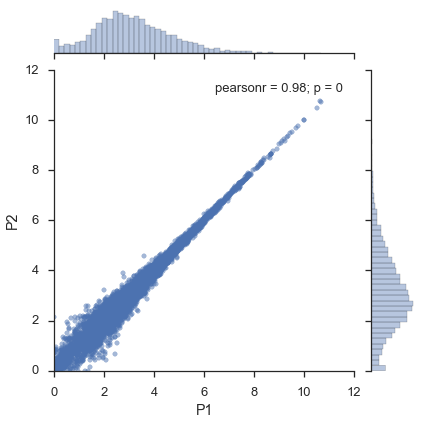

In [39]:
import seaborn as sns
sns.set_style('ticks')

x = expression_filtered.ix['P1']
y = expression_filtered.ix['P2']
jointgrid = sns.jointplot(x, y, joint_kws=dict(alpha=0.5))
xmin, xmax, ymin, ymax = jointgrid.ax_joint.axis()
jointgrid.ax_joint.set_xlim(0, xmax)
jointgrid.ax_joint.set_ylim(0, ymax);

### Figure 1b

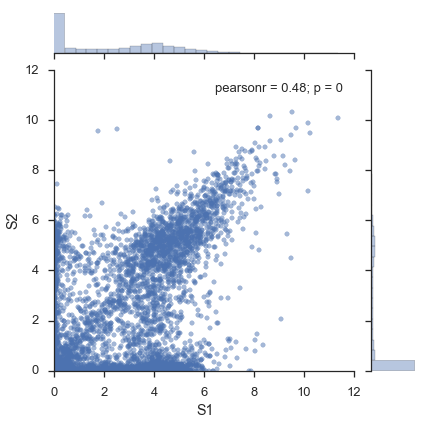

In [41]:
import seaborn as sns
sns.set_style('ticks')

x = expression_filtered.ix['S1']
y = expression_filtered.ix['S2']
jointgrid = sns.jointplot(x, y, joint_kws=dict(alpha=0.5))

# Adjust xmin, ymin to 0
xmin, xmax, ymin, ymax = jointgrid.ax_joint.axis()
jointgrid.ax_joint.set_xlim(0, xmax)
jointgrid.ax_joint.set_ylim(0, ymax);

By the way, you can do other kinds of plots with `flotilla`, like a kernel density estimate ("`kde`") plot:

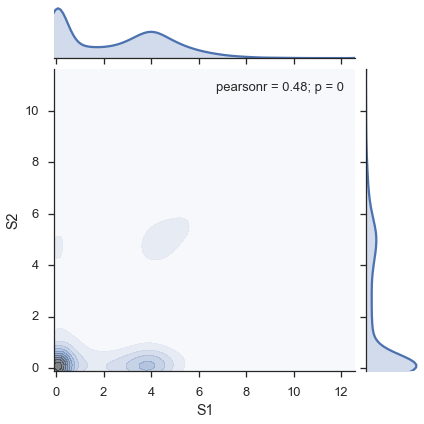

In [42]:
study.plot_two_samples('S1', 'S2', kind='kde')

Or a binned hexagon plot ("`hexbin"`):

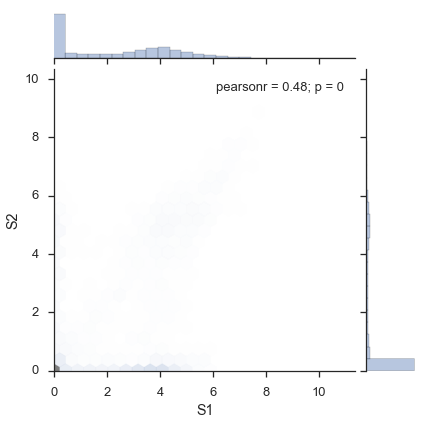

In [43]:
study.plot_two_samples('S1', 'S2', kind='hexbin')

Any inputs that are valid to `seaborn`'s [`jointplot`](http://web.stanford.edu/~mwaskom/software/seaborn/generated/seaborn.jointplot.html#seaborn.jointplot) are valid.

### Figure 1c

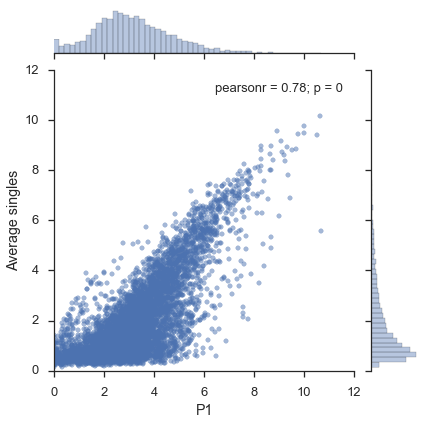

In [44]:
x = study.expression.data.ix['P1']
y = study.expression.singles.mean()
y.name = "Average singles"

jointgrid = sns.jointplot(x, y, joint_kws=dict(alpha=0.5))

# Adjust xmin, ymin to 0
xmin, xmax, ymin, ymax = jointgrid.ax_joint.axis()
jointgrid.ax_joint.set_xlim(0, xmax)
jointgrid.ax_joint.set_ylim(0, ymax);

## Figure 2


Next, we will attempt to recreate the figures from [Figure 2](http://www.nature.com/nature/journal/v498/n7453/fig_tab/nature12172_F2.html):

![Original figure 2](http://www.nature.com/nature/journal/v498/n7453/images/nature12172-f2.2.jpg)



### Figure 2a



For this figure, we will need the "LPS Response" and "Housekeeping" gene annotations, from the `expression_feature_data` that we created.

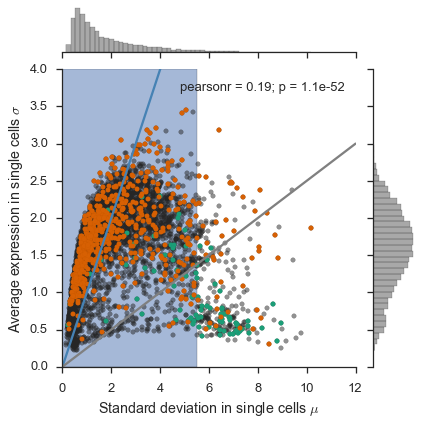

In [45]:
# Get colors for plotting the gene categories
dark2 = sns.color_palette('Dark2')

singles = study.expression.singles
# Get only gene categories for genes in the singles data
singles, gene_categories = singles.align(study.expression.feature_data.gene_category, join='left', axis=1)

mean = singles.mean()
std = singles.std()

jointgrid = sns.jointplot(mean, std, color='#262626', joint_kws=dict(alpha=0.5))

for i, (category, s) in enumerate(gene_categories.groupby(gene_categories)):
    jointgrid.ax_joint.plot(mean[s.index], std[s.index], 'o', color=dark2[i], markersize=5)

jointgrid.ax_joint.set_xlabel('Standard deviation in single cells $\mu$')
jointgrid.ax_joint.set_ylabel('Average expression in single cells $\sigma$')

xmin, xmax, ymin, ymax = jointgrid.ax_joint.axis()
vmax = max(xmax, ymax)
vmin = min(xmin, ymin)
jointgrid.ax_joint.plot([0, vmax], [0, vmax], color='steelblue')
jointgrid.ax_joint.plot([0, vmax], [0, .25*vmax], color='grey')
jointgrid.ax_joint.set_xlim(0, xmax)
jointgrid.ax_joint.set_ylim(0, ymax)

jointgrid.ax_joint.fill_betweenx((ymin, ymax), 0, np.log(250), alpha=0.5, zorder=-1);

I couldn't find the data for the `hESC`s for the right-side panel of Fig. 2a, so I couldn't remake the figure.

### Figure 2b



In the paper, they use *"522 most highly expressed genes (single-cell average TPM > 250)"*, but I wasn't able to replicate their numbers. If I use the pre-filtered expression data that I fed into flotilla, then I get 297 genes:

In [32]:
mean = study.expression.singles.mean()
highly_expressed_genes = mean.index[mean > np.log(250 + 1)]
len(highly_expressed_genes)

297

Which is much less. If I use the original, unfiltered data, then I get the *"522"* number, but this seems strange because they did the filtering step of *"discarded genes not appreciably expressed (transcripts per million (TPM) > 1) in at least three individual cells, retaining 6,313 genes for further analysis"*, and yet they went back to the original data to get this new subset.

In [33]:
expression.ix[:, expression.ix[singles_ids].mean() > 250].shape

(21, 522)

In [34]:
expression_highly_expressed = np.log(expression.ix[singles_ids, expression.ix[singles_ids].mean() > 250] + 1)

mean = expression_highly_expressed.mean()

std = expression_highly_expressed.std()

mean_bins = pd.cut(mean, bins=np.arange(0, 11, 1))

# Coefficient of variation
cv = std/mean
cv.sort()

genes = mean.index


# for name, df in shalek2013.expression.singles.groupby(dict(zip(genes, mean_bins)), axis=1):
def calculate_cells_per_tpm_per_cv(df, cv):
    df = df[df > 1]
    df_aligned, cv_aligned = df.align(cv, join='inner', axis=1)
    cv_aligned.sort()
    n_cells = pd.Series(0, index=cv.index)
    n_cells[cv_aligned.index] = df_aligned.ix[:, cv_aligned.index].count()
    return n_cells

grouped = expression_highly_expressed.groupby(dict(zip(genes, mean_bins)), axis=1)
cells_per_tpm_per_cv = grouped.apply(calculate_cells_per_tpm_per_cv, cv=cv)

Here's how you would make the original figure from the paper:

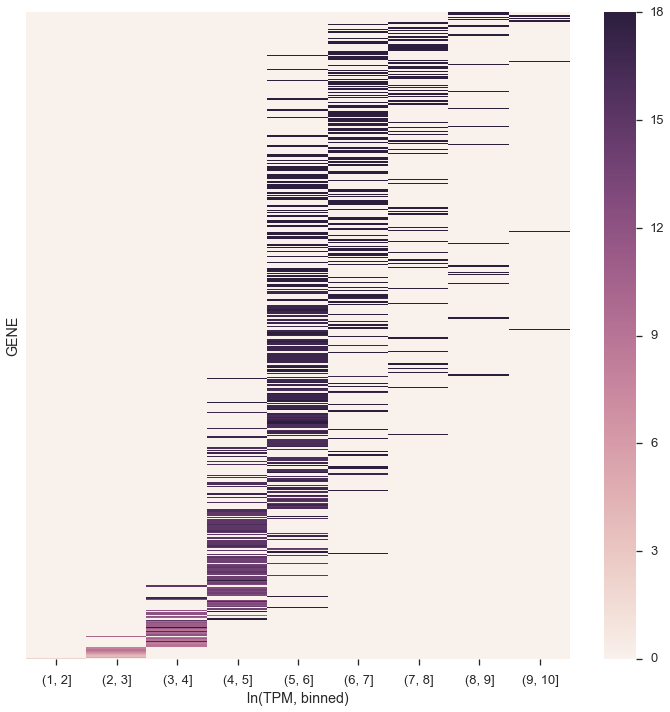

In [35]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cells_per_tpm_per_cv, linewidth=0, ax=ax, yticklabels=False)
ax.set_yticks([])
ax.set_xlabel('ln(TPM, binned)');

Doesn't quite look the same. Maybe the y-axis labels were opposite, and higher up on the y-axis was less variant? Because I see a blob of color for (1,2] TPM (by the way, the figure in the paper is not TPM+1 as previous figures were)

This is how you would make a modified version of the figure, which also plots the coefficient of variation on a side-plot, which I like because it shows the CV changes directly on the heatmap. Also, technically this is $\ln$(TPM+1).

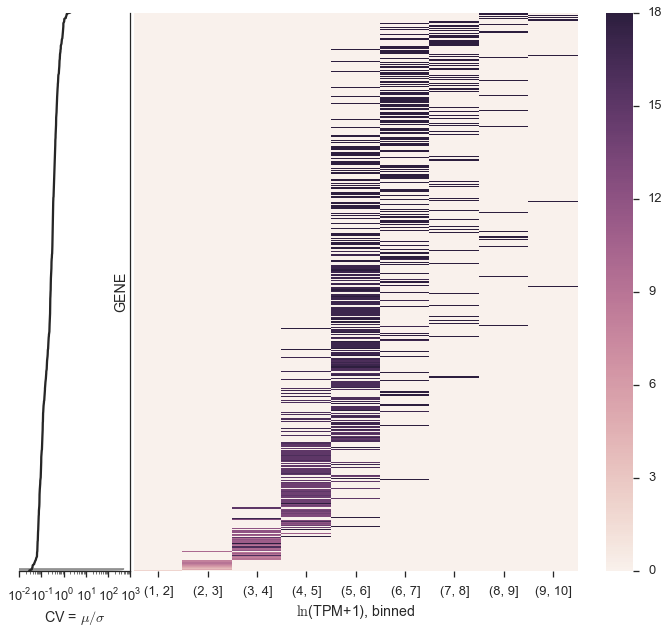

In [36]:
from matplotlib import gridspec

fig = plt.figure(figsize=(12, 10))

gs = gridspec.GridSpec(1, 2, wspace=0.01, hspace=0.01, width_ratios=[.2, 1])
cv_ax = fig.add_subplot(gs[0, 0])
heatmap_ax = fig.add_subplot(gs[0, 1])

sns.heatmap(cells_per_tpm_per_cv, linewidth=0, ax=heatmap_ax)
heatmap_ax.set_yticks([])
heatmap_ax.set_xlabel('$\ln$(TPM+1), binned')

y = np.arange(cv.shape[0])
cv_ax.set_xscale('log')
cv_ax.plot(cv, y, color='#262626')
cv_ax.fill_betweenx(cv, np.zeros(cv.shape), y, color='#262626', alpha=0.5)
cv_ax.set_ylim(0, y.max())
cv_ax.set_xlabel('CV = $\mu/\sigma$')
cv_ax.set_yticks([])
sns.despine(ax=cv_ax, left=True, right=False)

## Figure 3


We will attempt to re-create the sub-panel figures from [Figure 3](http://www.nature.com/nature/journal/v498/n7453/fig_tab/nature12172_F3.html):

![Original Figure 3](http://www.nature.com/nature/journal/v498/n7453/images/nature12172-f3.2.jpg)

Since we can't re-do the microscopy (Figure 3a) or the RNA-FISH counts (Figure 3c), we will make Figures 3b. These histograms are simple to do outside of `flotilla`, so we do not have them within flotilla.

### Figure 3b, top panel

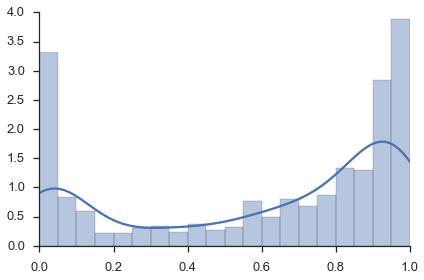

In [37]:
fig, ax = plt.subplots()
sns.distplot(study.splicing.singles.values.flat, bins=np.arange(0, 1.05, 0.05), ax=ax)
ax.set_xlim(0, 1)
sns.despine()

### Figure 3b, bottom panel

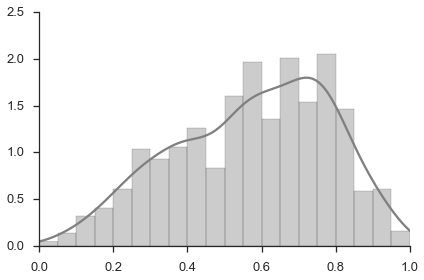

In [38]:
fig, ax = plt.subplots()
sns.distplot(study.splicing.pooled.values.flat, bins=np.arange(0, 1.05, 0.05), ax=ax, color='grey')
ax.set_xlim(0, 1)
sns.despine()

## Figure 4


We will attempt to re-create the sub-panel figures from [Figure 4](http://www.nature.com/nature/journal/v498/n7453/fig_tab/nature12172_F4.html):

![Original Figure 4](http://www.nature.com/nature/journal/v498/n7453/images/nature12172-f4.2.jpg)

### Figure 4a


Here, we can use the "`interactive_pca`" function we have to explore different dimensionality reductions on the data.

Equivalently, I could have written out the plotting command by hand, instead of using `study.interactive_pca`:

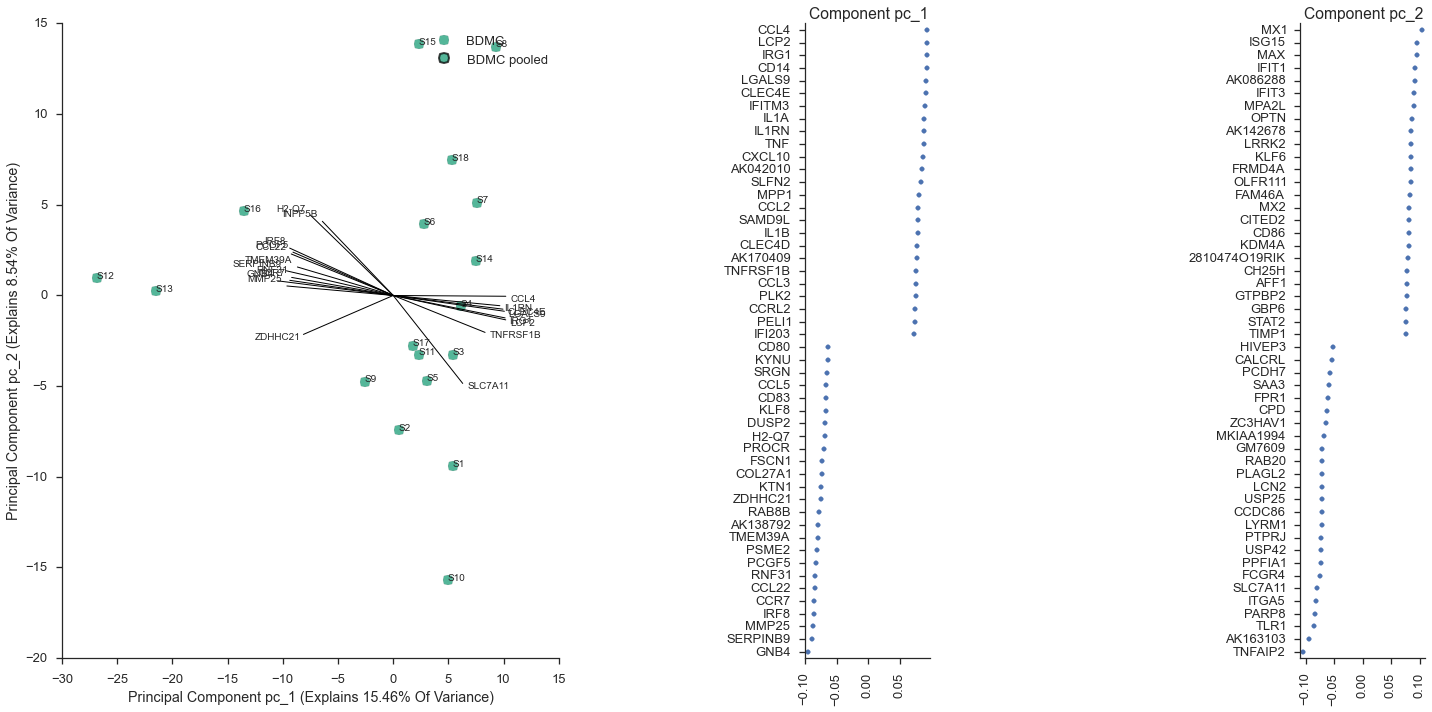

In [40]:
study.plot_pca(feature_subset='gene_category: LPS Response', sample_subset='not (pooled)', plot_violins=False, show_point_labels=True)

### Mark immature cells as a new subset

As in the paper, the cells S12, S13, and S16 appear in a cluster that is separate from the remaining cells. From the paper, these were the "matured" bone-marrow derived dendritic cells, after stimulation with a lipopolysaccharide. We can mark these as mature in our metadata,

In [48]:
mature = ['S12', 'S13', 'S16']
study.metadata.data['maturity'] = metadata.index.map(lambda x: 'mature' if x in mature else 'immature')
study.metadata.data.head()

,phenotype,pooled,outlier,maturity
S1,BDMC,False,False,immature
S2,BDMC,False,False,immature
S3,BDMC,False,False,immature
S4,BDMC,False,False,immature
S5,BDMC,False,False,immature


Then, we can set **maturity** as the column we use for coloring the PCA, since before it was the "phenotype" column.

In [49]:
study.metadata.phenotype_col = 'maturity'
study.save('shalek2013')
study = flotilla.embark('shalek2013')

Wrote datapackage to /Users/olga/flotilla_projects/shalek2013/datapackage.json2014-12-10 15:41:07	Reading datapackage from /Users/olga/flotilla_projects/shalek2013/datapackage.json
2014-12-10 15:41:07	Parsing datapackage to create a Study object
2014-12-10 15:41:07	Initializing Study
2014-12-10 15:41:07	Initializing Predictor configuration manager for Study
2014-12-10 15:41:07	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2014-12-10 15:41:07	Added ExtraTreesClassifier to default predictors
2014-12-10 15:41:07	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2014-12-10 15:41:07	Added ExtraTreesRegressor to default predictors
2014-12-10 15:41:07	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2014-12-10 15:41:07	Added GradientBoostingClassifier to default predictors
2014-12-10 15:41:07	Predictor GradientBoostingRegressor 

No color was assigned to the phenotype immature, assigning a random colorNo color was assigned to the phenotype mature, assigning a random colorimmature does not have marker style, falling back on "o" (circle)mature does not have marker style, falling back on "o" (circle)

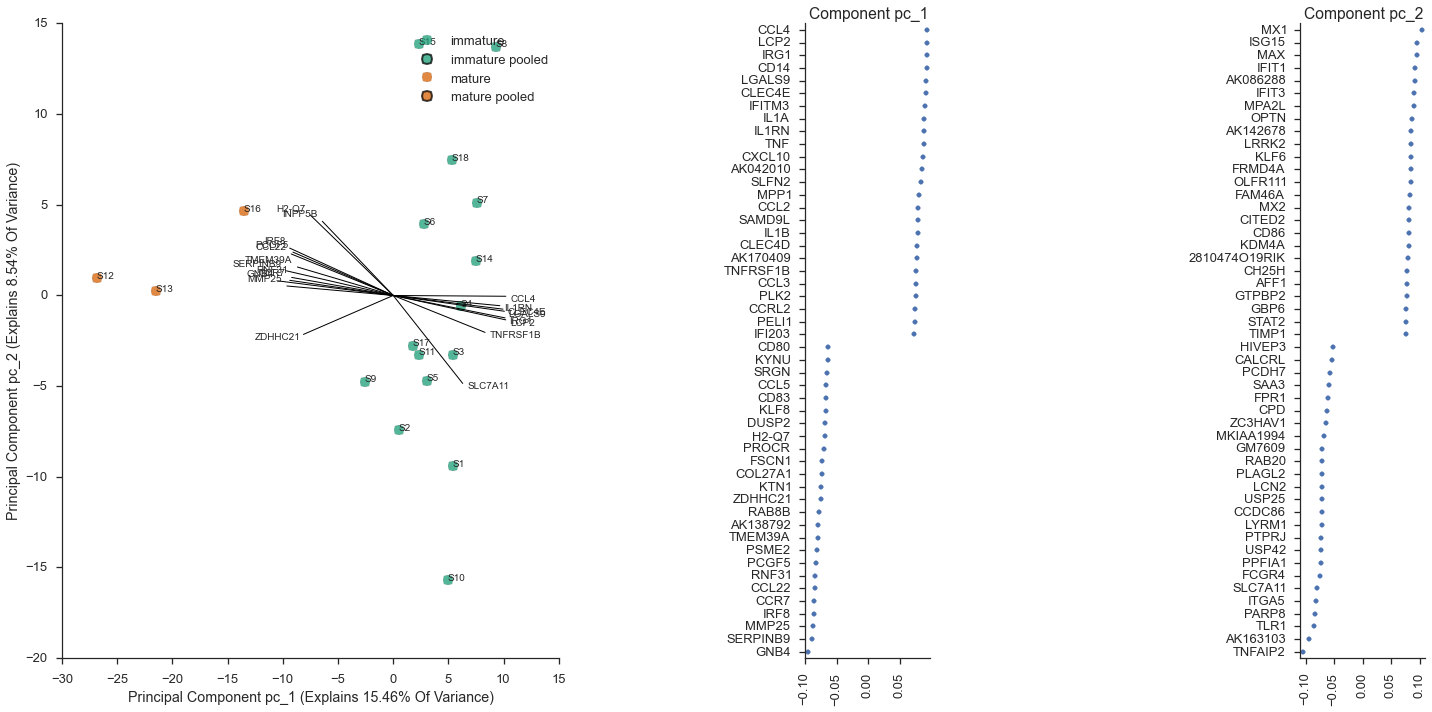

In [50]:
study.plot_pca(feature_subset='gene_category: LPS Response', sample_subset='not (pooled)', plot_violins=False, show_point_labels=True)

In [51]:
study.save('shalek2013')

Wrote datapackage to /Users/olga/flotilla_projects/shalek2013/datapackage.json

Without `flotilla`, `plot_pca` is quite a bit of code:

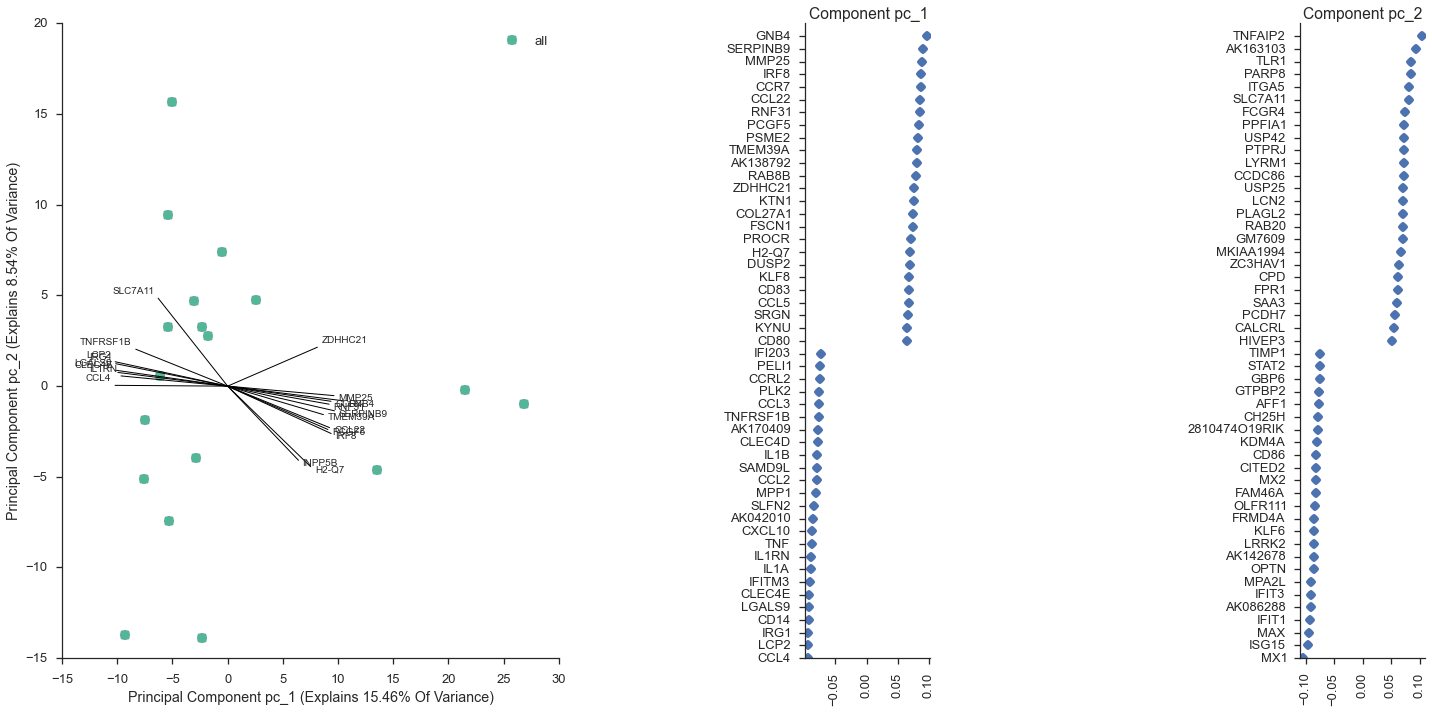

In [41]:
import sys
from collections import defaultdict
from itertools import cycle
import math

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
import pandas as pd
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from flotilla.visualize.color import dark2
from flotilla.visualize.generic import violinplot


class DataFrameReducerBase(object):
    """

    Just like scikit-learn's reducers, but with prettied up DataFrames.

    """

    def __init__(self, df, n_components=None, **decomposer_kwargs):

        # This magically initializes the reducer like DataFramePCA or DataFrameNMF
        if df.shape[1] <= 3:
            raise ValueError(
                "Too few features (n={}) to reduce".format(df.shape[1]))
        super(DataFrameReducerBase, self).__init__(n_components=n_components,
                                                   **decomposer_kwargs)
        self.reduced_space = self.fit_transform(df)

    def relabel_pcs(self, x):
        return "pc_" + str(int(x) + 1)

    def fit(self, X):
        try:
            assert type(X) == pd.DataFrame
        except AssertionError:
            sys.stdout.write("Try again as a pandas DataFrame")
            raise ValueError('Input X was not a pandas DataFrame, '
                             'was of type {} instead'.format(str(type(X))))

        self.X = X
        super(DataFrameReducerBase, self).fit(X)
        self.components_ = pd.DataFrame(self.components_,
                                        columns=self.X.columns).rename_axis(
            self.relabel_pcs, 0)
        try:
            self.explained_variance_ = pd.Series(
                self.explained_variance_).rename_axis(self.relabel_pcs, 0)
            self.explained_variance_ratio_ = pd.Series(
                self.explained_variance_ratio_).rename_axis(self.relabel_pcs,
                                                            0)
        except AttributeError:
            pass

        return self

    def transform(self, X):
        component_space = super(DataFrameReducerBase, self).transform(X)
        if type(self.X) == pd.DataFrame:
            component_space = pd.DataFrame(component_space,
                                           index=X.index).rename_axis(
                self.relabel_pcs, 1)
        return component_space

    def fit_transform(self, X):
        try:
            assert type(X) == pd.DataFrame
        except:
            sys.stdout.write("Try again as a pandas DataFrame")
            raise ValueError('Input X was not a pandas DataFrame, '
                             'was of type {} instead'.format(str(type(X))))
        self.fit(X)
        return self.transform(X)


class DataFramePCA(DataFrameReducerBase, decomposition.PCA):
    pass


class DataFrameNMF(DataFrameReducerBase, decomposition.NMF):
    def fit(self, X):
        """
        duplicated fit code for DataFrameNMF because sklearn's NMF cheats for
        efficiency and calls fit_transform. MRO resolves the closest
        (in this package)
        _single_fit_transform first and so there's a recursion error:

            def fit(self, X, y=None, **params):
                self._single_fit_transform(X, **params)
                return self
        """

        try:
            assert type(X) == pd.DataFrame
        except:
            sys.stdout.write("Try again as a pandas DataFrame")
            raise ValueError('Input X was not a pandas DataFrame, '
                             'was of type {} instead'.format(str(type(X))))

        self.X = X
        # notice this is fit_transform, not fit
        super(decomposition.NMF, self).fit_transform(X)
        self.components_ = pd.DataFrame(self.components_,
                                        columns=self.X.columns).rename_axis(
            self.relabel_pcs, 0)
        return self


class DataFrameICA(DataFrameReducerBase, decomposition.FastICA):
    pass

class DecompositionViz(object):
    """
    Plots the reduced space from a decomposed dataset. Does not perform any
    reductions of its own
    """

    def __init__(self, reduced_space, components_,
                 explained_variance_ratio_,
                 feature_renamer=None, groupby=None,
                 singles=None, pooled=None, outliers=None,
                 featurewise=False,
                 order=None, violinplot_kws=None,
                 data_type='expression', label_to_color=None,
                 label_to_marker=None,
                 scale_by_variance=True, x_pc='pc_1',
                 y_pc='pc_2', n_vectors=20, distance='L1',
                 n_top_pc_features=50, max_char_width=30):
        """Plot the results of a decomposition visualization

        Parameters
        ----------
        reduced_space : pandas.DataFrame
            A (n_samples, n_dimensions) DataFrame of the post-dimensionality
            reduction data
        components_ : pandas.DataFrame
            A (n_features, n_dimensions) DataFrame of how much each feature
            contributes to the components (trailing underscore to be
            consistent with scikit-learn)
        explained_variance_ratio_ : pandas.Series
            A (n_dimensions,) Series of how much variance each component
            explains. (trailing underscore to be consistent with scikit-learn)
        feature_renamer : function, optional
            A function which takes the name of the feature and renames it,
            e.g. from an ENSEMBL ID to a HUGO known gene symbol. If not
            provided, the original name is used.
        groupby : mapping function | dict, optional
            A mapping of the samples to a label, e.g. sample IDs to
            phenotype, for the violinplots. If None, all samples are treated
            the same and are colored the same.
        singles : pandas.DataFrame, optional
            For violinplots only. If provided and 'plot_violins' is True,
            will plot the raw (not reduced) measurement values as violin plots.
        pooled : pandas.DataFrame, optional
            For violinplots only. If provided, pooled samples are plotted as
            black dots within their label.
        outliers : pandas.DataFrame, optional
            For violinplots only. If provided, outlier samples are plotted as
            a grey shadow within their label.
        featurewise : bool, optional
            If True, then the "samples" are features, e.g. genes instead of
            samples, and the "features" are the samples, e.g. the cells
            instead of the gene ids. Essentially, the transpose of the
            original matrix. If True, then violins aren't plotted. (default
            False)
        order : list-like
            The order of the labels for the violinplots, e.g. if the data is
            from a differentiation timecourse, then this would be the labels
            of the phenotypes, in the differentiation order.
        violinplot_kws : dict
            Any additional parameters to violinplot
        data_type : 'expression' | 'splicing', optional
            For violinplots only. The kind of data that was originally used
            for the reduction. (default 'expression')
        label_to_color : dict, optional
            A mapping of the label, e.g. the phenotype, to the desired
            plotting color (default None, auto-assigned with the groupby)
        label_to_marker : dict, optional
            A mapping of the label, e.g. the phenotype, to the desired
            plotting symbol (default None, auto-assigned with the groupby)
        scale_by_variance : bool, optional
            If True, scale the x- and y-axes by their explained_variance_ratio_
            (default True)
        {x,y}_pc : str, optional
            Principal component to plot on the x- and y-axis. (default "pc_1"
            and "pc_2")
        n_vectors : int, optional
            Number of vectors to plot of the principal components. (default 20)
        distance : 'L1' | 'L2', optional
            The distance metric to use to plot the vector lengths. L1 is
            "Cityblock", i.e. the sum of the x and y coordinates, and L2 is
            the traditional Euclidean distance. (default "L1")
        n_top_pc_features : int, optional
            THe number of top features from the principal components to plot.
            (default 50)
        max_char_width : int, optional
            Maximum character width of a feature name. Useful for crazy long
            feature IDs like MISO IDs
        """
        self.reduced_space = reduced_space
        self.components_ = components_
        self.explained_variance_ratio_ = explained_variance_ratio_

        self.singles = singles
        self.pooled = pooled
        self.outliers = outliers

        self.groupby = groupby
        self.order = order
        self.violinplot_kws = violinplot_kws if violinplot_kws is not None \
            else {}
        self.data_type = data_type
        self.label_to_color = label_to_color
        self.label_to_marker = label_to_marker
        self.n_vectors = n_vectors
        self.x_pc = x_pc
        self.y_pc = y_pc
        self.pcs = (self.x_pc, self.y_pc)
        self.distance = distance
        self.n_top_pc_features = n_top_pc_features
        self.featurewise = featurewise
        self.feature_renamer = feature_renamer
        self.max_char_width = max_char_width

        if self.label_to_color is None:
            colors = cycle(dark2)

            def color_factory():
                return colors.next()

            self.label_to_color = defaultdict(color_factory)

        if self.label_to_marker is None:
            markers = cycle(['o', '^', 's', 'v', '*', 'D', 'h'])

            def marker_factory():
                return markers.next()

            self.label_to_marker = defaultdict(marker_factory)

        if self.groupby is None:
            self.groupby = dict.fromkeys(self.reduced_space.index, 'all')
        self.grouped = self.reduced_space.groupby(self.groupby, axis=0)
        if order is not None:
            self.color_ordered = [self.label_to_color[x] for x in self.order]
        else:
            self.color_ordered = [self.label_to_color[x] for x in
                                  self.grouped.groups]

        self.loadings = self.components_.ix[[self.x_pc, self.y_pc]]

        # Get the explained variance
        if explained_variance_ratio_ is not None:
            self.vars = explained_variance_ratio_[[self.x_pc, self.y_pc]]
        else:
            self.vars = pd.Series([1., 1.], index=[self.x_pc, self.y_pc])

        if scale_by_variance:
            self.loadings = self.loadings.multiply(self.vars, axis=0)

        # sort features by magnitude/contribution to transformation
        reduced_space = self.reduced_space[[self.x_pc, self.y_pc]]
        farthest_sample = reduced_space.apply(np.linalg.norm, axis=0).max()
        whole_space = self.loadings.apply(np.linalg.norm).max()
        scale = .25 * farthest_sample / whole_space
        self.loadings *= scale

        ord = 2 if self.distance == 'L2' else 1
        self.magnitudes = self.loadings.apply(np.linalg.norm, ord=ord)
        self.magnitudes.sort(ascending=False)

        self.top_features = set([])
        self.pc_loadings_labels = {}
        self.pc_loadings = {}
        for pc in self.pcs:
            x = self.components_.ix[pc].copy()
            x.sort(ascending=True)
            half_features = int(self.n_top_pc_features / 2)
            if len(x) > self.n_top_pc_features:
                a = x[:half_features]
                b = x[-half_features:]
                labels = np.r_[a.index, b.index]
                self.pc_loadings[pc] = np.r_[a, b]
            else:
                labels = x.index
                self.pc_loadings[pc] = x

            self.pc_loadings_labels[pc] = labels
            self.top_features.update(labels)

    def __call__(self, ax=None, title='', plot_violins=True,
                 show_point_labels=False,
                 show_vectors=True,
                 show_vector_labels=True,
                 markersize=10, legend=True):
        gs_x = 14
        gs_y = 12

        if ax is None:
            self.reduced_fig, ax = plt.subplots(1, 1, figsize=(20, 10))
            gs = GridSpec(gs_x, gs_y)

        else:
            gs = GridSpecFromSubplotSpec(gs_x, gs_y, ax.get_subplotspec())
            self.reduced_fig = plt.gcf()

        ax_components = plt.subplot(gs[:, :5])
        ax_loading1 = plt.subplot(gs[:, 6:8])
        ax_loading2 = plt.subplot(gs[:, 10:14])

        self.plot_samples(show_point_labels=show_point_labels,
                          title=title, show_vectors=show_vectors,
                          show_vector_labels=show_vector_labels,
                          markersize=markersize, legend=legend,
                          ax=ax_components)
        self.plot_loadings(pc=self.x_pc, ax=ax_loading1)
        self.plot_loadings(pc=self.y_pc, ax=ax_loading2)
        sns.despine()
        self.reduced_fig.tight_layout()

        if plot_violins and not self.featurewise and self.singles is not None:
            self.plot_violins()
        return self

    def shorten(self, x):
        if len(x) > self.max_char_width:
            return '{}...'.format(x[:self.max_char_width])
        else:
            return x

    def plot_samples(self, show_point_labels=True,
                     title='DataFramePCA', show_vectors=True,
                     show_vector_labels=True, markersize=10,
                     three_d=False, legend=True, ax=None):

        """
        Given a pandas dataframe, performs DataFramePCA and plots the results in a
        convenient single function.

        Parameters
        ----------
        groupby : groupby
            How to group the samples by color/label
        label_to_color : dict
            Group labels to a matplotlib color E.g. if you've already chosen
            specific colors to indicate a particular group. Otherwise will
            auto-assign colors
        label_to_marker : dict
            Group labels to matplotlib marker
        title : str
            title of the plot
        show_vectors : bool
            Whether or not to draw the vectors indicating the supporting
            principal components
        show_vector_labels : bool
            whether or not to draw the names of the vectors
        show_point_labels : bool
            Whether or not to label the scatter points
        markersize : int
            size of the scatter markers on the plot
        text_group : list of str
            Group names that you want labeled with text
        three_d : bool
            if you want hte plot in 3d (need to set up the axes beforehand)

        Returns
        -------
        For each vector in data:
        x, y, marker, distance
        """
        if ax is None:
            ax = plt.gca()

        # Plot the samples
        for name, df in self.grouped:
            color = self.label_to_color[name]
            marker = self.label_to_marker[name]
            x = df[self.x_pc]
            y = df[self.y_pc]
            ax.plot(x, y, color=color, marker=marker, linestyle='None',
                    label=name, markersize=markersize, alpha=0.75,
                    markeredgewidth=.1)
            try:
                if not self.pooled.empty:
                    pooled_ids = x.index.intersection(self.pooled.index)
                    pooled_x, pooled_y = x[pooled_ids], y[pooled_ids]
                    ax.plot(pooled_x, pooled_y, 'o', color=color, marker=marker,
                            markeredgecolor='k', markeredgewidth=2,
                            label='{} pooled'.format(name),
                            markersize=markersize, alpha=0.75)
            except AttributeError:
                pass
            try:
                if not self.outliers.empty:
                    outlier_ids = x.index.intersection(self.outliers.index)
                    outlier_x, outlier_y = x[outlier_ids], y[outlier_ids]
                    ax.plot(outlier_x, outlier_y, 'o', color=color,
                            marker=marker,
                            markeredgecolor='lightgrey', markeredgewidth=5,
                            label='{} outlier'.format(name),
                            markersize=markersize, alpha=0.75)
            except AttributeError:
                pass
            if show_point_labels:
                for args in zip(x, y, df.index):
                    ax.text(*args)

        # Plot vectors, if asked
        if show_vectors:
            for vector_label in self.magnitudes[:self.n_vectors].index:
                x, y = self.loadings[vector_label]
                ax.plot([0, x], [0, y], color='k', linewidth=1)
                if show_vector_labels:
                    x_offset = math.copysign(5, x)
                    y_offset = math.copysign(5, y)
                    horizontalalignment = 'left' if x > 0 else 'right'
                    if self.feature_renamer is not None:
                        renamed = self.feature_renamer(vector_label)
                    else:
                        renamed = vector_label
                    ax.annotate(renamed, (x, y),
                                textcoords='offset points',
                                xytext=(x_offset, y_offset),
                                horizontalalignment=horizontalalignment)

        # Label x and y axes
        ax.set_xlabel(
            'Principal Component {} (Explains {:.2f}% Of Variance)'.format(
                str(self.x_pc), 100 * self.vars[self.x_pc]))
        ax.set_ylabel(
            'Principal Component {} (Explains {:.2f}% Of Variance)'.format(
                str(self.y_pc), 100 * self.vars[self.y_pc]))
        ax.set_title(title)

        if legend:
            ax.legend()
        sns.despine()

    def plot_loadings(self, pc='pc_1', n_features=50, ax=None):
        loadings = self.pc_loadings[pc]
        labels = self.pc_loadings_labels[pc]

        if ax is None:
            ax = plt.gca()

        ax.plot(loadings, np.arange(loadings.shape[0]), 'o')

        ax.set_yticks(np.arange(max(loadings.shape[0], n_features)))
        ax.set_title("Component " + pc)

        x_offset = max(loadings) * .05
        ax.set_xlim(left=loadings.min() - x_offset,
                    right=loadings.max() + x_offset)

        if self.feature_renamer is not None:
            labels = map(self.feature_renamer, labels)
        else:
            labels = labels

        labels = map(self.shorten, labels)
        # ax.set_yticklabels(map(shorten, labels))
        ax.set_yticklabels(labels)
        for lab in ax.get_xticklabels():
            lab.set_rotation(90)
        sns.despine(ax=ax)

    def plot_explained_variance(self, title="PCA explained variance"):
        """If the reducer is a form of PCA, then plot the explained variance
        ratio by the components.
        """
        # Plot the explained variance ratio
        assert self.explained_variance_ratio_ is not None
        import matplotlib.pyplot as plt
        import seaborn as sns

        fig, ax = plt.subplots()
        ax.plot(self.explained_variance_ratio_, 'o-')

        xticks = np.arange(len(self.explained_variance_ratio_))
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks + 1)
        ax.set_xlabel('Principal component')
        ax.set_ylabel('Fraction explained variance')
        ax.set_title(title)
        sns.despine()

    def plot_violins(self):
        """Make violinplots of each feature

        Must be called after plot_samples because it depends on the existence
        of the "self.magnitudes" attribute.
        """
        ncols = 4
        nrows = 1
        vector_labels = list(set(self.magnitudes[:self.n_vectors].index.union(
            pd.Index(self.top_features))))
        while ncols * nrows < len(vector_labels):
            nrows += 1
        self.violins_fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                                              figsize=(4 * ncols, 4 * nrows))

        if self.feature_renamer is not None:
            renamed_vectors = map(self.feature_renamer, vector_labels)
        else:
            renamed_vectors = vector_labels
        labels = [(y, x) for (y, x) in sorted(zip(renamed_vectors,
                                                  vector_labels))]

        for (renamed, feature_id), ax in zip(labels, axes.flat):
            singles = self.singles[feature_id] if self.singles is not None \
                else None
            pooled = self.pooled[feature_id] if self.pooled is not None else \
                None
            outliers = self.outliers[feature_id] if self.outliers is not None \
                else None
            title = '{}\n{}'.format(feature_id, renamed)
            violinplot(singles, pooled_data=pooled, outliers=outliers,
                       groupby=self.groupby, color_ordered=self.color_ordered,
                       order=self.order, title=title,
                       ax=ax, data_type=self.data_type,
                       **self.violinplot_kws)

        # Clear any unused axes
        for ax in axes.flat:
            # Check if the plotting space is empty
            if len(ax.collections) == 0 or len(ax.lines) == 0:
                ax.axis('off')
        self.violins_fig.tight_layout()

# Notice we're using the original data, nothing from "study"
lps_response_genes = expression_feature_data.index[expression_feature_data.gene_category == 'LPS Response']
subset = expression_filtered.ix[singles_ids, lps_response_genes].dropna(how='all', axis=1)
subset_standardized = pd.DataFrame(StandardScaler().fit_transform(subset),
                                       index=subset.index, columns=subset.columns)


pca = DataFramePCA(subset_standardized)
visualizer = DecompositionViz(pca.reduced_space, pca.components_, pca.explained_variance_ratio_)
visualizer();

### Figure 4b

In [42]:
lps_response_genes = study.expression.feature_subsets['gene_category: LPS Response']
lps_response = study.expression.singles.ix[:, lps_response_genes].dropna(how='all', axis=1)
lps_response.head()

GENE,1110018G07RIK,1110038F14RIK,1200009I06RIK,1600014C10RIK,1810029B16RIK,2210009G21RIK,2810474O19RIK,3110001I22RIK,4921513D23RIK,4930523C07RIK,...,ZC3H12C,ZC3HAV1,ZCCHC2,ZCCHC6,ZDHHC21,ZFP36,ZFP800,ZHX2,ZNFX1,ZUFSP
S1,3.711442,0.000000,3.275468,0.000000,5.609305,0,0.000000,3.828860,1.314573,3.778275,...,3.972904,3.509979,0.035344,3.042277,4.425735,4.092559,4.025124,0.779382,2.998800,0.000000
S2,4.361671,0.147643,0.000000,0.000000,5.478071,0,3.407342,0.000000,1.531443,0.000000,...,4.794306,4.984262,2.251330,1.018315,4.955713,0.356008,4.297776,0.032569,3.091207,5.000843
S3,0.000000,3.737014,2.987093,0.063526,5.320993,0,3.372359,0.058163,1.105115,0.025043,...,4.882749,0.807258,0.094925,0.126673,3.952273,1.956983,0.000000,0.000000,3.794063,2.928699
S4,2.719587,0.000000,0.045823,0.000000,0.488049,0,5.127847,0.000000,2.303969,0.000000,...,4.833354,4.538699,0.137427,2.025546,4.193989,2.372572,0.121924,0.000000,0.230278,0.430168
S5,2.982073,0.000000,2.829152,0.000000,5.093188,0,0.065122,4.635671,1.015640,0.461296,...,4.446634,0.157178,0.616401,0.000000,4.039816,0.000000,4.714087,1.565475,0.860254,4.866979


In [43]:
lps_response_corr = lps_response.corr()

#### "Elbow method" for determining number of clusters

The authors state that they used the "Elbow method" to determine the [number of cluster centers](http://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set). Essentially, you try a bunch of different $k$, and see where there is a flattening out of the metric, like an elbow. There's a few different variations on which metric to use, such as using the average distance to the cluster center, or the explained variance. Let's try the distance to cluster center first, because `scikit-learn` makes it easy.

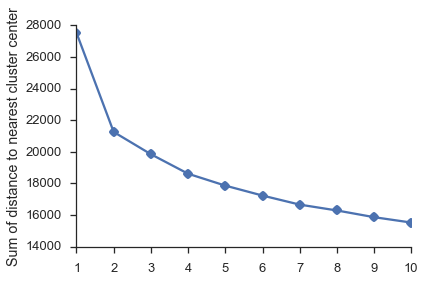

In [44]:
from sklearn.cluster import KMeans

##### cluster data into K=1..10 clusters #####
ks = np.arange(1, 11).astype(int)

X = lps_response_corr.values

kmeans = [KMeans(n_clusters=k).fit(X) for k in ks]

# Scikit-learn makes this easy by computing the distance to the nearest center
dist_to_center = [km.inertia_ for km in kmeans]

fig, ax = plt.subplots()
ax.plot(ks, dist_to_center, 'o-')
ax.set_ylabel('Sum of distance to nearest cluster center')
sns.despine()

Not quite sure where the elbow is here. looks like there's a big drop off after $k=1$, but that could just be an illusion. Since they didn't specify which version of the elbow method they used, I'm not going to investigate this further, and just see if we can see what they see with the $k=5$ clusters that they found was optimal.



In [45]:
kmeans = KMeans(n_clusters=5)
lps_response_corr_clusters = kmeans.fit_predict(lps_response_corr.values)
lps_response_corr_clusters

array([3, 0, 4, 4, 1, 0, 3, 4, 2, 4, 1, 3, 2, 4, 3, 3, 1, 0, 1, 3, 1, 0, 2,
       1, 1, 3, 3, 2, 4, 4, 1, 4, 4, 1, 4, 1, 3, 4, 2, 0, 2, 4, 2, 3, 0, 4,
       1, 1, 4, 0, 0, 3, 4, 1, 1, 2, 1, 1, 1, 2, 0, 3, 4, 3, 3, 4, 2, 2, 4,
       3, 1, 4, 1, 3, 4, 2, 2, 4, 2, 3, 3, 3, 0, 0, 4, 1, 2, 2, 2, 0, 0, 3,
       0, 0, 4, 3, 3, 3, 3, 0, 0, 2, 1, 2, 1, 1, 2, 1, 2, 4, 2, 1, 1, 3, 4,
       4, 1, 2, 4, 3, 4, 2, 2, 2, 0, 4, 4, 1, 0, 2, 3, 3, 4, 4, 1, 1, 4, 3,
       2, 0, 1, 4, 2, 1, 4, 2, 4, 1, 0, 1, 1, 3, 3, 3, 3, 0, 0, 3, 1, 2, 2,
       3, 4, 0, 0, 4, 2, 2, 2, 3, 3, 3, 3, 1, 3, 3, 0, 1, 2, 0, 0, 1, 2, 4,
       1, 0, 3, 2, 0, 3, 1, 0, 0, 2, 4, 3, 0, 1, 1, 1, 3, 3, 2, 0, 3, 0, 4,
       4, 4, 3, 2, 3, 3, 0, 4, 3, 4, 3, 1, 0, 3, 3, 3, 3, 3, 0, 4, 0, 1, 3,
       3, 2, 4, 3, 4, 1, 1, 3, 0, 0, 2, 4, 2, 4, 4, 3, 0, 3, 0, 1, 4, 0, 0,
       1, 1, 4, 1, 1, 1, 0, 4, 3, 4, 3, 3, 3, 3, 1, 3, 4, 4, 2, 2, 0, 2, 2,
       1, 1, 1, 4, 1, 2, 4, 1, 2, 2, 1, 4, 1, 3, 0, 3, 2, 3, 1, 3, 3, 3, 2,
       0, 2,

Now let's create a dataframe with these genes in their cluster orders.

In [46]:
gene_to_cluster = dict(zip(lps_response_corr.columns, lps_response_corr_clusters))

dfs = []
for name, df in lps_response_corr.groupby(gene_to_cluster):
    dfs.append(df)
lps_response_corr_ordered_by_clusters = pd.concat(dfs)

# Make symmetric, since we created this dataframe by smashing rows on top of each other, we need to reorder the columns
lps_response_corr_ordered_by_clusters = lps_response_corr_ordered_by_clusters.ix[:, lps_response_corr_ordered_by_clusters.index]
lps_response_corr_ordered_by_clusters.head()

GENE,1110038F14RIK,2210009G21RIK,A430084P05RIK,AA960436,AK141659,AK163103,ALCAM,ALPK2,ARMC8,BC147527,...,TNFAIP2,TNFSF4,TOR1AIP1,TRA2A,TRIM26,TRIM34,TTC39C,USP12,ZC3H12C,ZC3HAV1
GENE,,,,,,,,,,,,,,,,,,,,,
1110038F14RIK,1.000000,0.175230,0.043846,0.240304,0.150073,-0.007459,-0.075510,0.001210,0.078638,-0.073983,...,-0.053588,-0.085191,0.322774,0.096905,-0.370932,0.451829,0.387727,-0.257008,0.274102,-0.163423
2210009G21RIK,0.175230,1.000000,0.301786,0.454579,-0.106546,-0.122179,0.177472,0.215454,0.540303,0.078574,...,0.230309,-0.158622,0.019694,0.142045,0.053967,0.483106,-0.085604,0.279262,0.153934,0.160710
A430084P05RIK,0.043846,0.301786,1.000000,0.001150,0.060210,-0.173020,0.150884,0.429134,0.131837,-0.069652,...,-0.341757,-0.296639,-0.192074,-0.360383,0.025340,0.033636,-0.227960,-0.166541,0.200579,0.064736
AA960436,0.240304,0.454579,0.001150,1.000000,-0.361780,0.206889,0.174208,0.075687,0.394432,0.163830,...,0.175022,-0.271395,0.272221,-0.222182,0.181522,-0.094028,0.218182,0.396040,-0.159072,0.048122
AK141659,0.150073,-0.106546,0.060210,-0.361780,1.000000,-0.287830,-0.370827,0.143026,-0.019682,-0.157671,...,-0.295535,0.194073,-0.232992,0.061276,-0.032583,0.411637,-0.182131,0.018036,0.175434,-0.288042


The next step is to get the principal-component reduced data, using only the LPS response genes. We can do this in `flotilla` using `study.expression.reduce`.

In [47]:
reduced = study.expression.reduce(singles_ids, feature_ids=lps_response_genes)

We can get the principal components using `reduced.components_` (similar interface as `scikit-learn`).

In [48]:
reduced.components_.head()

,MOV10,PPAP2B,LASS6,TMCO3,CPD,AK138792,TARM1,P4HA1,CD180,SMG7,...,OAS1B,OAS1G,AK151815,GTPBP2,PRPF38A,SLC7A11,PCDH7,GNA13,PTPRJ,ATF3
pc_1,0.035299,0.038725,-0.006343,0.014219,0.033734,-0.079831,0.032886,0.034783,0.033719,-0.048453,...,-0.022490,0.031091,-0.021397,0.034917,0.001745,0.058000,0.007748,0.000767,0.016012,0.018020
pc_2,0.055310,0.002925,-0.043986,-0.024020,-0.061957,-0.016327,0.002882,-0.003178,0.050055,0.038601,...,0.012240,0.052127,0.009120,0.077015,0.072064,-0.080902,-0.056607,0.068444,-0.072533,0.068088
pc_3,0.000374,0.099514,-0.039636,0.003997,-0.000575,-0.042212,-0.056827,0.015571,-0.039811,0.005398,...,-0.010524,-0.009277,-0.102462,-0.043913,-0.052513,-0.030622,0.022607,-0.002503,0.023997,-0.054205
pc_4,0.022491,0.002342,0.009422,-0.034725,0.025866,-0.009656,-0.027689,-0.089803,-0.046888,0.002274,...,-0.003404,-0.070307,-0.007025,0.003407,-0.048078,0.028099,0.032970,-0.066284,0.010371,-0.006108
pc_5,-0.025743,-0.009200,-0.030187,-0.061283,0.010464,0.032668,0.012223,-0.047623,-0.047351,0.045909,...,-0.074817,0.044218,-0.000884,-0.000597,-0.033893,-0.018108,-0.012669,-0.025833,-0.044248,-0.001995


In [49]:
pc_components = reduced.components_.ix[:2, lps_response_corr_ordered_by_clusters.index].T
pc_components.head()

,pc_1,pc_2
GENE,,
1110038F14RIK,-0.007729,-0.005858
2210009G21RIK,-0.006981,0.002916
A430084P05RIK,0.014550,0.022191
AA960436,0.002159,0.014470
AK141659,0.016902,-0.009151


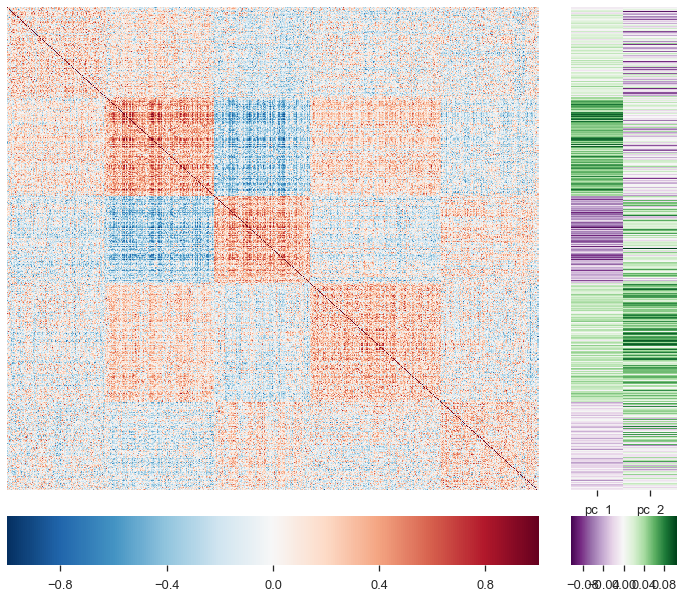

In [50]:
import matplotlib as mpl

fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 2, wspace=0.1, hspace=0.1, width_ratios=[1, .2], height_ratios=[1, .1])
corr_ax = fig.add_subplot(gs[0, 0])
corr_cbar_ax = fig.add_subplot(gs[1, 0])
pc_ax = fig.add_subplot(gs[0, 1:])
pc_cbar_ax = fig.add_subplot(gs[1:, 1:])

sns.heatmap(lps_response_corr_ordered_by_clusters, linewidth=0, ax=corr_ax, cbar_ax=corr_cbar_ax, 
            cbar_kws=dict(orientation='horizontal'))
sns.heatmap(pc_components, cmap=mpl.cm.PRGn, linewidth=0, ax=pc_ax, cbar_ax=pc_cbar_ax,
            cbar_kws=dict(orientation='horizontal'))

corr_ax.set_xlabel('')
corr_ax.set_ylabel('')
corr_ax.set_xticks([])
corr_ax.set_yticks([])
pc_ax.set_yticks([])
pc_ax.set_ylabel('')

This looks pretty similar, maybe just rearranged cluster order. Let's check what their data looks like when you plot this.

#### Their PC scores and clusters for the genes

In [51]:
gene_pc_clusters = pd.read_excel('nature12172-s1/Supplementary_Table5.xls', index_col=0)
gene_pc_clusters.head()

,Annotation,Cluster,PC1 Score,PC2 Score
Gene,,,,
LNPEP,NaN,1,0.232368,0.677266
TOR1AIP2,Antiv,1,-0.075934,1.485877
TNFSF4,NaN,1,0.497893,-0.562412
CFB,Inflam,1,-0.394318,1.277749
H2-T10,NaN,1,0.514947,-0.698538


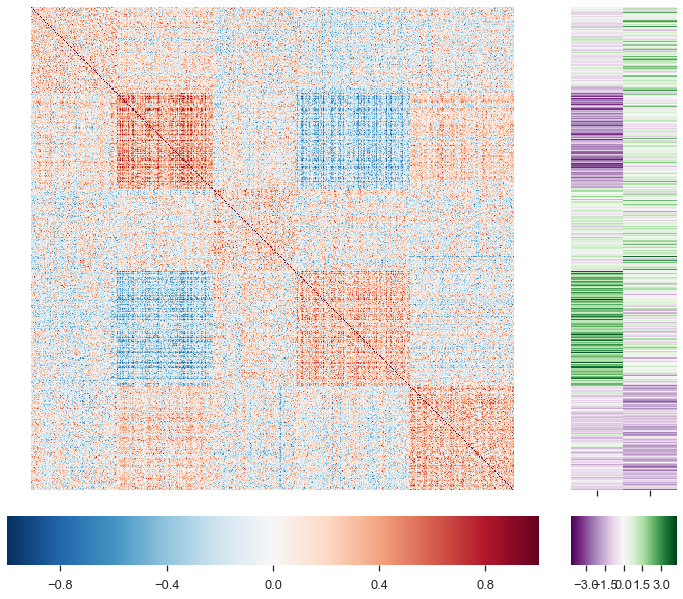

In [52]:
data = lps_response_corr.ix[gene_pc_clusters.index, gene_pc_clusters.index].dropna(how='all', axis=0).dropna(how='all', axis=1)

fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 2, wspace=0.1, hspace=0.1, width_ratios=[1, .2], height_ratios=[1, .1])
corr_ax = fig.add_subplot(gs[0, 0])
corr_cbar_ax = fig.add_subplot(gs[1, 0])
pc_ax = fig.add_subplot(gs[0, 1:])
pc_cbar_ax = fig.add_subplot(gs[1:, 1:])

sns.heatmap(data, linewidth=0, square=True, vmin=-1, vmax=1, ax=corr_ax, cbar_ax=corr_cbar_ax, cbar_kws=dict(orientation='horizontal'))
sns.heatmap(gene_pc_clusters.ix[:, ['PC1 Score', 'PC2 Score']], linewidth=0, cmap=mpl.cm.PRGn,
            ax=pc_ax, cbar_ax=pc_cbar_ax, cbar_kws=dict(orientation='horizontal'), xticklabels=False, yticklabels=False)

corr_ax.set_xlabel('')
corr_ax.set_ylabel('')
corr_ax.set_xticks([])
corr_ax.set_yticks([])

pc_ax.set_yticks([])
pc_ax.set_ylabel('');

Sure enough, if I use their annotations, I get exactly that. Though there were two genes in their file that I didn't have in the `lps_response_corr` data:

In [53]:
gene_pc_clusters.index.difference(lps_response_corr.index)

TypeError: can't compare datetime.datetime to unicode

Oh joy, another `datetime` error, just like we had with `expression2`... Looking back at the original Excel file, there is one gene that Excel mangled to be a date:

![](https://raw.githubusercontent.com/olgabot/olgabot.github.io-source/master/content/images/shalek2013_supplementary_table_5_datetime_error.png)

Please, can we start using just plain ole `.csv`s for supplementary data! Excel does NOT preserve strings if they start with numbers, and instead thinks they are dates.

In [54]:
import collections
collections.Counter(gene_pc_clusters.index.map(type))

Counter({<type 'unicode'>: 631, <type 'datetime.datetime'>: 1})

Yep, it's just that one that got mangled.... oh well.

In [55]:
gene_pc_clusters_genes = set(filter(lambda x: isinstance(x, unicode), gene_pc_clusters.index))
gene_pc_clusters_genes.difference(lps_response_corr.index)

{u'RPS6KA2'}

So, "`RPS6KA2`" is the only gene that was in their list of genes and not in mine.

## Supplementary figures

Now we get to have even more fun by plotting the Supplementary figures! :D

Ironically, the supplementary figures are usually way easier to access (like not behind a paywall), and yet they're usually the documents that really have the crucial information about the experiments.

### Supplementary Figure 1

![Supplementary figure 1, a correlation plot](https://raw.githubusercontent.com/olgabot/olgabot.github.io-source/master/content/images/shalek2013_sfig1.png)

In [56]:
singles_mean = study.expression.singles.mean()
singles_mean.name = 'Single cell average'

# Need to convert "average_singles" to a DataFrame instead of a single-row Series
singles_mean = pd.DataFrame(singles_mean)
singles_mean.head()
 

,Single cell average
GENE,
NPL,1.075740
QK,2.019888
AK163153,1.429369
PARK2,0.596479
AGPAT4,2.021294


In [57]:
data_for_correlations = pd.concat([study.expression.singles, singles_mean.T, study.expression.pooled])

# Take the transpose of the data, because the plotting algorithm calculates correlations between columns,
# And we want the correlations between samples, not features
data_for_correlations = data_for_correlations.T
data_for_correlations.head()

# %time sns.corrplot(data_for_correlations)

,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,...,S13,S14,S15,S16,S17,S18,Single cell average,P1,P2,P3
GENE,,,,,,,,,,,,,,,,,,,,,
NPL,4.290577,0.000000,4.860293,0.090829,0.000000,0.000000,4.730129,4.657090,0.112641,0.000000,...,0.110470,0.099121,0.100920,0.206361,0.104884,0.000000,1.075740,2.093019,2.044724,2.742480
QK,5.038477,4.183371,3.847854,0.066797,3.305915,0.114225,3.730270,2.750103,0.134389,0.760353,...,3.395885,2.294456,0.301120,3.547688,2.185832,0.040923,2.019888,3.869102,3.690982,3.671838
AK163153,1.249363,1.947622,1.082463,1.119633,1.267464,0.901824,1.033401,0.978591,1.220720,1.035237,...,2.103135,1.110511,1.202271,4.446612,1.367261,0.428320,1.429369,0.605094,0.392494,0.284990
PARK2,0.540694,0.500426,0.604097,0.418703,0.000000,0.601280,0.404931,0.552874,0.343271,0.844120,...,0.755072,1.109400,0.807534,0.586962,0.485122,0.091469,0.596479,0.815242,0.267032,0.645365
AGPAT4,0.095072,5.868557,4.137252,0.066015,0.000000,4.750107,0.069345,4.130618,3.328758,0.000000,...,0.000000,4.430612,0.000000,0.000000,4.219120,0.171028,2.021294,2.854144,2.139655,2.806291


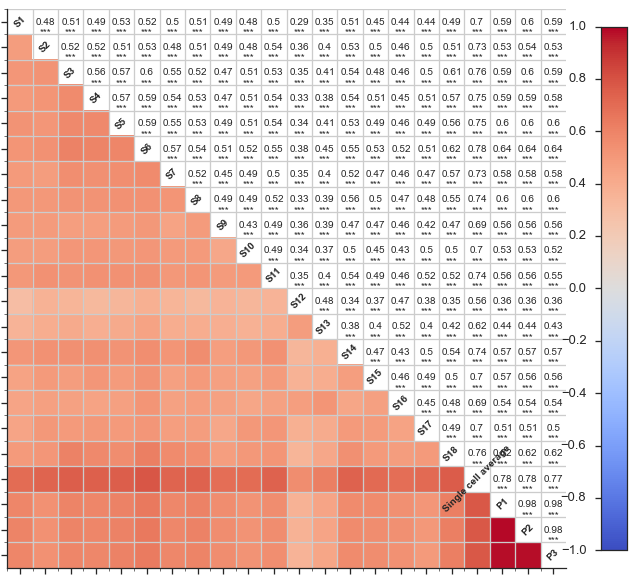

In [58]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.corrplot(data_for_correlations, ax=ax)
sns.despine()

Notice that this is mostly red, while in the figure from the paper, it was both blue and red. This is because the colormap started at 0.2 (not negative), and was centered with white at about 0.6. I see that they're trying to emphasize how much more correlated the pooled samples are to each other, but I think a simple sequential map would have been more effective.

### Supplementary Figures 2 and 3

Supplementary [Figure 2](https://raw.githubusercontent.com/olgabot/olgabot.github.io-source/master/content/images/shalek2013_sfig2.png) and [Figure 3](https://raw.githubusercontent.com/olgabot/olgabot.github.io-source/master/content/images/shalek2013_sfig3.png) are from FISH and raw sequence data, and are out of the scope of this computational reproduction.

### Supplementary Figure 4

[Supplementary Figure 4](https://raw.githubusercontent.com/olgabot/olgabot.github.io-source/master/content/images/shalek2013_sfig4.png) was from published data, however the citation in the Supplementary Information (#23) was a [machine-learning book](http://link.springer.com/book/10.1007%2F978-3-642-51175-2), and #23 in the main text citations was a [review of probabilistic graphical models](http://www.sciencemag.org/content/303/5659/799.full), neither of which have the mouse embryonic stem cells or mouse embryonic fibroblasts used in the figure.





### Supplementary Figure 5

For this figure, we can only plot 5d, since it's derived directly from a table in their dataset.

Warning: these data are going to require some serious cleaning. Yay data janitorial duties!

![](https://raw.githubusercontent.com/olgabot/olgabot.github.io-source/master/content/images/shalek2013_sfig5.png)



#### Supplementary Figure 5d

In [59]:
barcoded = pd.read_excel('nature12172-s1/Supplementary_Table7.xlsx')
barcoded.head()

,TPM,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unique Barcodes,Unnamed: 5,Unnamed: 6
GENE,MB_S1,MB_S2,MB_S3,NaN,MB_S1,MB_S2,MB_S3
0610007L01RIK,0,0,5.595054,NaN,0,0,0
0610007P14RIK,76.25091,38.77614,0.1823286,NaN,23,8,0
0610007P22RIK,24.26729,50.24694,17.74422,NaN,14,5,6
0610008F07RIK,0,0,0,NaN,0,0,0


The first three columns are TPM calculated from the three samples that have molecular barcodes, and the last three columns are the integer counts of molecular barcodes from the three molecular barcode samples.

Let's remove the "Unnamed: 3" column which is all NaNs. We'll do that with the `.dropna` method, specifying `axis=1` for columns and `how="all"` to make sure only columns that have ALL NaNs are removed.

In [60]:
barcoded = barcoded.dropna(how='all', axis=1)
barcoded.head()

,TPM,Unnamed: 1,Unnamed: 2,Unique Barcodes,Unnamed: 5,Unnamed: 6
GENE,MB_S1,MB_S2,MB_S3,MB_S1,MB_S2,MB_S3
0610007L01RIK,0,0,5.595054,0,0,0
0610007P14RIK,76.25091,38.77614,0.1823286,23,8,0
0610007P22RIK,24.26729,50.24694,17.74422,14,5,6
0610008F07RIK,0,0,0,0,0,0


Next, let's drop that pesky "GENE" row. Don't worry, we'll get the sample ID names back next.

In [61]:
barcoded = barcoded.drop('GENE', axis=0)
barcoded.head()

,TPM,Unnamed: 1,Unnamed: 2,Unique Barcodes,Unnamed: 5,Unnamed: 6
0610007L01RIK,0,0,5.595054,0,0,0
0610007P14RIK,76.25091,38.77614,0.1823286,23,8,0
0610007P22RIK,24.26729,50.24694,17.74422,14,5,6
0610008F07RIK,0,0,0,0,0,0
0610009B22RIK,67.12981,115.1393,55.98812,11,18,8


We'll create a `pandas.MultiIndex` from the tuples of `(sample_id, measurement_type)` pair.

In [62]:
columns = pd.MultiIndex.from_tuples([('MB_S1', 'TPM'),
           ('MB_S2', 'TPM'),
           ('MB_S3', 'TPM'),
           ('MB_S1', 'Unique Barcodes'),
           ('MB_S2', 'Unique Barcodes'),
           ('MB_S3', 'Unique Barcodes')])
barcoded.columns = columns
barcoded = barcoded.sort_index(axis=1)
barcoded.head()

MB_S1                     MB_S2                      MB_S3  \
                    TPM Unique Barcodes       TPM Unique Barcodes        TPM   
0610007L01RIK         0               0         0               0   5.595054   
0610007P14RIK  76.25091              23  38.77614               8  0.1823286   
0610007P22RIK  24.26729              14  50.24694               5   17.74422   
0610008F07RIK         0               0         0               0          0   
0610009B22RIK  67.12981              11  115.1393              18   55.98812   

                               
              Unique Barcodes  
0610007L01RIK               0  
0610007P14RIK               0  
0610007P22RIK               6  
0610008F07RIK               0  
0610009B22RIK               8

For the next move, we're going to do some crazy `pandas`-fu. First we're going to transpose, then `reset_index` of the transpose. Just so you know what this looks like, it's this.

In [63]:
barcoded.T.reset_index().head()

,level_0,level_1,0610007L01RIK,0610007P14RIK,0610007P22RIK,0610008F07RIK,0610009B22RIK,0610009D07RIK,0610009O20RIK,0610010B08RIK,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,MB_S1,TPM,0,76.25091,24.26729,0,67.12981,132.2392,17.03907,0.01375923,...,0,206.8494,0,0,0,0,0.01985733,55.28996,0.09482778,0
1,MB_S1,Unique Barcodes,0,23,14,0,11,29,3,1,...,0,33,0,0,0,0,0,6,0,0
2,MB_S2,TPM,0,38.77614,50.24694,0,115.1393,49.16287,0,0,...,0,48.7729,0,0,0,0,7.894789,135.1977,0,4.272594
3,MB_S2,Unique Barcodes,0,8,5,0,18,11,0,0,...,0,10,0,0,0,0,0,7,0,0
4,MB_S3,TPM,5.595054,0.1823286,17.74422,0,55.98812,203.6302,0,0.4914763,...,0,54.51386,1.120081,0,0,0,0.1238624,340.7358,0.6677646,0


Next, we're going to transform the data into a [tidy](http://vita.had.co.nz/papers/tidy-data.pdf) format, with separate columns for sample ids, measurement types, the gene that was measured, and its measurement value.

In [64]:
barcoded_tidy = pd.melt(barcoded.T.reset_index(), id_vars=['level_0', 'level_1'])
barcoded_tidy.head()

,level_0,level_1,variable,value
0,MB_S1,TPM,0610007L01RIK,0
1,MB_S1,Unique Barcodes,0610007L01RIK,0
2,MB_S2,TPM,0610007L01RIK,0
3,MB_S2,Unique Barcodes,0610007L01RIK,0
4,MB_S3,TPM,0610007L01RIK,5.595054


Now let's rename these columns into something more useful, instead of "level_0"

In [65]:
barcoded_tidy = barcoded_tidy.rename(columns={'level_0': 'sample_id', 'level_1': 'measurement', 'variable': 'gene_name'})
barcoded_tidy.head()

,sample_id,measurement,gene_name,value
0,MB_S1,TPM,0610007L01RIK,0
1,MB_S1,Unique Barcodes,0610007L01RIK,0
2,MB_S2,TPM,0610007L01RIK,0
3,MB_S2,Unique Barcodes,0610007L01RIK,0
4,MB_S3,TPM,0610007L01RIK,5.595054


Next, we're going to take some seemingly-duplicating steps, but trust me, it'll make the data easier.

In [66]:
barcoded_tidy['TPM'] = barcoded_tidy.value[barcoded_tidy.measurement == 'TPM']
barcoded_tidy['Unique Barcodes'] = barcoded_tidy.value[barcoded_tidy.measurement == 'Unique Barcodes']

Fill the values of the "**TPM**"'s forwards, since they appear first, and fill the values of the "**Unique Barcodes**" backwards, since they're second

In [67]:
barcoded_tidy.TPM = barcoded_tidy.TPM.ffill()
barcoded_tidy['Unique Barcodes'] = barcoded_tidy['Unique Barcodes'].bfill()
barcoded_tidy.head()

,sample_id,measurement,gene_name,value,TPM,Unique Barcodes
0,MB_S1,TPM,0610007L01RIK,0,0.000000,0
1,MB_S1,Unique Barcodes,0610007L01RIK,0,0.000000,0
2,MB_S2,TPM,0610007L01RIK,0,0.000000,0
3,MB_S2,Unique Barcodes,0610007L01RIK,0,0.000000,0
4,MB_S3,TPM,0610007L01RIK,5.595054,5.595054,0


Drop the "**measurement**" column and drop duplicate rows.

In [68]:
barcoded_tidy = barcoded_tidy.drop('measurement', axis=1)
barcoded_tidy = barcoded_tidy.drop_duplicates()
barcoded_tidy.head()

,sample_id,gene_name,value,TPM,Unique Barcodes
0,MB_S1,0610007L01RIK,0,0.000000,0
2,MB_S2,0610007L01RIK,0,0.000000,0
4,MB_S3,0610007L01RIK,5.595054,5.595054,0
5,MB_S3,0610007L01RIK,0,5.595054,0
6,MB_S1,0610007P14RIK,76.25091,76.250913,23


In [69]:
barcoded_tidy['log TPM'] = np.log(barcoded_tidy.TPM)
barcoded_tidy['log Unique Barcodes'] = np.log(barcoded_tidy['Unique Barcodes'])

Now we can use the convenient linear model plot (`lmplot`) in `seaborn` to plot these three samples together!

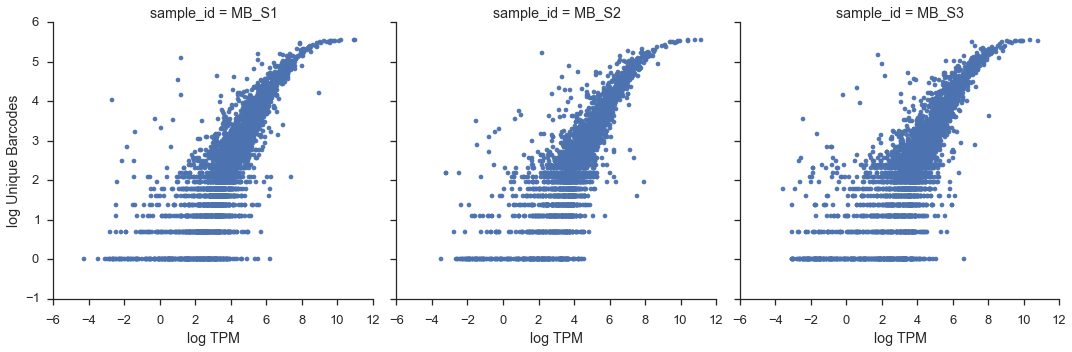

In [70]:
sns.lmplot('log TPM', 'log Unique Barcodes', barcoded_tidy, col='sample_id')

### Supplementary Figures 6-20

Supplementary Figures [6](https://raw.githubusercontent.com/olgabot/olgabot.github.io-source/master/content/images/shalek2013_sfig6.png), 
[7](https://raw.githubusercontent.com/olgabot/olgabot.github.io-source/master/content/images/shalek2013_sfig7.png),
[8](https://raw.githubusercontent.com/olgabot/olgabot.github.io-source/master/content/images/shalek2013_sfig8.png), 
[9](https://raw.githubusercontent.com/olgabot/olgabot.github.io-source/master/content/images/shalek2013_sfig9.png), 
[10](https://raw.githubusercontent.com/olgabot/olgabot.github.io-source/master/content/images/shalek2013_sfig10.png), 
[11](https://raw.githubusercontent.com/olgabot/olgabot.github.io-source/master/content/images/shalek2013_sfig11.png), 
[12](https://raw.githubusercontent.com/olgabot/olgabot.github.io-source/master/content/images/shalek2013_sfig12.png), 
[13](https://raw.githubusercontent.com/olgabot/olgabot.github.io-source/master/content/images/shalek2013_sfig13.png), 
[14](https://raw.githubusercontent.com/olgabot/olgabot.github.io-source/master/content/images/shalek2013_sfig14.png), 
[15](https://raw.githubusercontent.com/olgabot/olgabot.github.io-source/master/content/images/shalek2013_sfig15.png), 
[16](https://raw.githubusercontent.com/olgabot/olgabot.github.io-source/master/content/images/shalek2013_sfig16.png), 
[17](https://raw.githubusercontent.com/olgabot/olgabot.github.io-source/master/content/images/shalek2013_sfig17.png), 
[18](https://raw.githubusercontent.com/olgabot/olgabot.github.io-source/master/content/images/shalek2013_sfig18.png), 
[19](https://raw.githubusercontent.com/olgabot/olgabot.github.io-source/master/content/images/shalek2013_sfig19.png), and
[20](https://raw.githubusercontent.com/olgabot/olgabot.github.io-source/master/content/images/shalek2013_sfig20.png), 
deal with splicing data from the molecular barcodes, RNA-FISH, flow-sorted cells, and single-cell RT-PCR and are out of the scope of this reproduction.

## Conclusions

While there may be minor, undocumented, differences between the methods presented in the manuscript and the figures, the application of [`flotilla`](https://github.com/YeoLab/flotilla) presents an opportunity to avoid these types of inconsistencies by strictly documenting every change to code and every transformation of the data. The biology the authors found is clearly real, as they did the knockout experiment of *Ifnr-/-* and saw that indeed the maturation process was affected, and *Stat2* and *Irf7* had much lower expression, as with the "maturing" cells in the data.